# Plots

## Load data

In [1]:
import pandas as pd
import sys
sys.path.append('../')
from utils.plots import *
output_notebook()

file_path = '../data/'
model_name1 = 'AL Epigenomic Subtype'
model_name2 = 'AML Epigenomic Risk'
model_name3 = '38CpG-AMLsignature'

# Read the data
df = pd.read_excel(file_path + 'alma_main_results.xlsx', index_col=0).sort_index()
sig_results = pd.read_excel(file_path + 'signature_results.xlsx', index_col=0).sort_index()

df = df.join(sig_results)

# Define train and test samples
df_train = df[df['Train-Test']=='Train Sample']
df_test = df[df['Train-Test'] == 'Test Sample']

# remove duplicates from the test cohort
df_test = df_test[~df_test['Patient_ID'].duplicated(keep='last')]
df_test = df_test[~df_test['Clinical Trial'].isin(['UF HemBank'])]

# Prognostic model samples
df_px = df[~df['Vital Status at 5y'].isna()]
df_px2 = df_px[df_px['Clinical Trial'].isin(['AAML0531', 'AAML1031', 'AAML03P1'])]
df_px2 = df_px2[df_px2['Sample Type'].isin(
    ['Diagnosis', 'Primary Blood Derived Cancer - Bone Marrow', 'Primary Blood Derived Cancer - Peripheral Blood'])]
df_px2 = df_px2[~df_px2['Patient_ID'].duplicated(keep='last')]

# drop the samples with missing labels for the ELN AML 2022 Diagnosis
df_dx = df_train[~df_train['WHO 2022 Diagnosis'].isna()]

# exclude the classes with fewer than 5 samples
df_dx = df_dx[~df_dx['WHO 2022 Diagnosis'].isin(['AML with t(9;22); BCR::ABL1'])]

Loading BokehJS ...

## Patient Characteristics

### ALMA (unsupervised)

In [2]:
from tableone import TableOne
from datetime import date

columns = ['Hematopoietic Entity','Age (group years)','Sex',
            'Clinical Trial',]

mytable_cog = TableOne(df_train.reset_index(), columns,
                        overall=False, missing=False,
                        pval=False, pval_adjust=False,
                        htest_name=True,dip_test=True,
                        tukey_test=True, normal_test=True,

                        order={'FLT3 ITD':['Yes','No'],
                                'Age (group years)':['0-5','5-13','13-39','39-60'],
                                'MRD 1 Status': ['Positive'],
                                'Risk Group': ['High Risk', 'Standard Risk'],
                                'FLT3 ITD': ['Yes'],
                                'Leucocyte counts (10⁹/L)': ['≥30'],
                                'Age group (years)': ['≥10']})

mytable_cog.to_excel('../data/pt_characteristics_alma_model_' + str(date.today()) +'.xlsx')

mytable_cog.tabulate(tablefmt="html", 
                        # headers=[score_name,"",'Missing','Discovery','Validation','p-value','Statistical Test']
                        )

'<table>\n<thead>\n<tr><th>                           </th><th>                                          </th><th>Overall    </th></tr>\n</thead>\n<tbody>\n<tr><td>n                          </td><td>                                          </td><td>3314       </td></tr>\n<tr><td>Hematopoietic Entity, n (%)</td><td>Acute lymphoblastic leukemia (ALL)        </td><td>700 (28.3) </td></tr>\n<tr><td>                           </td><td>Acute myeloid leukemia (AML)              </td><td>1221 (49.4)</td></tr>\n<tr><td>                           </td><td>Acute promyelocytic leukemia (APL)        </td><td>31 (1.3)   </td></tr>\n<tr><td>                           </td><td>Mixed phenotype acute leukemia (MPAL)     </td><td>48 (1.9)   </td></tr>\n<tr><td>                           </td><td>Myelodysplastic syndrome (MDS or MDS-like)</td><td>223 (9.0)  </td></tr>\n<tr><td>                           </td><td>Otherwise-Normal (Control)                </td><td>251 (10.1) </td></tr>\n<tr><td>Age (group years), n (%)   </td><td>0-5                                       </td><td>480 (24.1) </td></tr>\n<tr><td>                           </td><td>5-13                                      </td><td>483 (24.2) </td></tr>\n<tr><td>                           </td><td>13-39                                     </td><td>663 (33.2) </td></tr>\n<tr><td>                           </td><td>39-60                                     </td><td>165 (8.3)  </td></tr>\n<tr><td>                           </td><td>60+                                       </td><td>203 (10.2) </td></tr>\n<tr><td>Sex, n (%)                 </td><td>Female                                    </td><td>885 (49.1) </td></tr>\n<tr><td>                           </td><td>Male                                      </td><td>918 (50.9) </td></tr>\n<tr><td>Clinical Trial, n (%)      </td><td>AAML03P1                                  </td><td>72 (2.2)   </td></tr>\n<tr><td>                           </td><td>AAML0531                                  </td><td>628 (18.9) </td></tr>\n<tr><td>                           </td><td>AAML1031                                  </td><td>587 (17.7) </td></tr>\n<tr><td>                           </td><td>BM normal AAML0531                        </td><td>41 (1.2)   </td></tr>\n<tr><td>                           </td><td>Beat AML Consortium                       </td><td>316 (9.5)  </td></tr>\n<tr><td>                           </td><td>CCG2961                                   </td><td>41 (1.2)   </td></tr>\n<tr><td>                           </td><td>CETLAM SMD-09 (MDS-tAML)                  </td><td>166 (5.0)  </td></tr>\n<tr><td>                           </td><td>French GRAALL 2003–2005                   </td><td>141 (4.3)  </td></tr>\n<tr><td>                           </td><td>Japanese AML05                            </td><td>64 (1.9)   </td></tr>\n<tr><td>                           </td><td>NOPHO ALL92-2000                          </td><td>933 (28.2) </td></tr>\n<tr><td>                           </td><td>TARGET ALL                                </td><td>131 (4.0)  </td></tr>\n<tr><td>                           </td><td>TCGA AML                                  </td><td>194 (5.9)  </td></tr>\n</tbody>\n</table>'

### Fine-tuned (supervised) Dx and Px models

In [3]:
columns = ['Age (years)','Age group (years)','Sex','Race or ethnic group',
            'Hispanic or Latino ethnic group', 'MRD 1 Status',
            'Leucocyte counts (10⁹/L)', 'BM leukemic blasts (%)',
            'Risk Group','FLT3 ITD', 'Clinical Trial']

df_test['Age (years)'] = df_test['Age (years)'].astype(float)


all_cohorts = pd.concat([df_dx, df_px2, df_test],
                         axis=0, keys=['Dx Discovery','Px Discovery' ,'Test '],
                         names=['cohort']).reset_index()

mytable_cog = TableOne(all_cohorts, columns,
                        overall=False, missing=False,
                        pval=False, pval_adjust=False,
                        htest_name=True,dip_test=True,
                        tukey_test=True, normal_test=True,

                        order={'FLT3 ITD':['Yes','No'],
                                'Race or ethnic group':['White','Black or African American','Asian'],
                                'MRD 1 Status': ['Positive'],
                                'Risk Group': ['High Risk', 'Standard Risk'],
                                'FLT3 ITD': ['Yes'],
                                'Leucocyte counts (10⁹/L)': ['≥30'],
                                'Age group (years)': ['≥10']},
                                groupby='cohort')

mytable_cog.to_excel('../data/pt_characteristics_fine-tuned_models_' + str(date.today()) +'.xlsx')

mytable_cog.tabulate(tablefmt="html", 
                        # headers=[score_name,"",score_name,'Validation','p-value','Statistical Test']
)

'<table>\n<thead>\n<tr><th>                                      </th><th>                                </th><th>Dx Discovery  </th><th>Px Discovery  </th><th>Test       </th></tr>\n</thead>\n<tbody>\n<tr><td>n                                     </td><td>                                </td><td>2471          </td><td>946           </td><td>200        </td></tr>\n<tr><td>Age (years), mean (SD)                </td><td>                                </td><td>19.2 (19.7)   </td><td>9.4 (6.3)     </td><td>8.8 (6.0)  </td></tr>\n<tr><td>Age group (years), n (%)              </td><td>≥10                             </td><td>528 (47.4)    </td><td>463 (48.9)    </td><td>95 (48.0)  </td></tr>\n<tr><td>                                      </td><td>&lt;10                             </td><td>586 (52.6)    </td><td>483 (51.1)    </td><td>103 (52.0) </td></tr>\n<tr><td>Sex, n (%)                            </td><td>Female                          </td><td>711 (50.5)    </td><td>468 (49.5)    </td><td>86 (43.0)  </td></tr>\n<tr><td>                                      </td><td>Male                            </td><td>697 (49.5)    </td><td>478 (50.5)    </td><td>114 (57.0) </td></tr>\n<tr><td>Race or ethnic group, n (%)           </td><td>White                           </td><td>1064 (80.5)   </td><td>697 (79.1)    </td><td>142 (71.7) </td></tr>\n<tr><td>                                      </td><td>Black or African American       </td><td>131 (9.9)     </td><td>102 (11.6)    </td><td>32 (16.2)  </td></tr>\n<tr><td>                                      </td><td>Asian                           </td><td>65 (4.9)      </td><td>43 (4.9)      </td><td>1 (0.5)    </td></tr>\n<tr><td>                                      </td><td>American Indian or Alaska Native</td><td>7 (0.5)       </td><td>5 (0.6)       </td><td>           </td></tr>\n<tr><td>                                      </td><td>Other                           </td><td>48 (3.6)      </td><td>28 (3.2)      </td><td>21 (10.6)  </td></tr>\n<tr><td>                                      </td><td>Pacific Islander                </td><td>7 (0.5)       </td><td>6 (0.7)       </td><td>2 (1.0)    </td></tr>\n<tr><td>Hispanic or Latino ethnic group, n (%)</td><td>Hispanic or Latino              </td><td>209 (19.6)    </td><td>185 (20.2)    </td><td>25 (12.6)  </td></tr>\n<tr><td>                                      </td><td>Not Hispanic or Latino          </td><td>858 (80.4)    </td><td>731 (79.8)    </td><td>173 (87.4) </td></tr>\n<tr><td>MRD 1 Status, n (%)                   </td><td>Positive                        </td><td>284 (29.6)    </td><td>260 (31.5)    </td><td>76 (40.4)  </td></tr>\n<tr><td>                                      </td><td>Negative                        </td><td>675 (70.4)    </td><td>566 (68.5)    </td><td>112 (59.6) </td></tr>\n<tr><td>Leucocyte counts (10⁹/L), n (%)       </td><td>≥30                             </td><td>579 (52.4)    </td><td>467 (49.4)    </td><td>87 (43.7)  </td></tr>\n<tr><td>                                      </td><td>&lt;30                             </td><td>526 (47.6)    </td><td>479 (50.6)    </td><td>112 (56.3) </td></tr>\n<tr><td>BM leukemic blasts (%), mean (SD)     </td><td>                                </td><td>65.7 (24.1)   </td><td>63.8 (24.5)   </td><td>60.2 (25.6)</td></tr>\n<tr><td>Risk Group, n (%)                     </td><td>High Risk                       </td><td>198 (14.2)    </td><td>129 (13.8)    </td><td>51 (25.5)  </td></tr>\n<tr><td>                                      </td><td>Standard Risk                   </td><td>628 (45.0)    </td><td>454 (48.7)    </td><td>86 (43.0)  </td></tr>\n<tr><td>                                      </td><td>Low Risk                        </td><td>570 (40.8)    </td><td>349 (37.4)    </td><td>63 (31.5)  </td></tr>\n<tr><td>FLT3 ITD, n (%)                       </td><td>Yes                             </td><td>180 (16.2)    </td><td>165 (17.5)    </td><td>31 (15.7)  </td></t

### By prognostic group

#### Discovery

AML Epigenomic Risk

In [4]:
def pt_characteristics_by_model(df, model_name2, traintest = 'discovery'):
        columns = ['Age (years)','Age group (years)','Sex','Race or ethnic group',
                'Hispanic or Latino ethnic group', 'MRD 1 Status',
                'Leucocyte counts (10⁹/L)', 'BM leukemic blasts (%)',
                'Risk Group', 'Clinical Trial','FLT3 ITD', 'Treatment Arm']

        mytable_cog = TableOne(df, columns,
                                overall=False, missing=False,
                                pval=True, pval_adjust=False,
                                htest_name=True,dip_test=True,
                                tukey_test=True, normal_test=True,

                                order={'FLT3 ITD':['Yes','No'],
                                        'Race or ethnic group':['White','Black or African American','Asian'],
                                        'MRD 1 Status': ['Positive'],
                                        'Risk Group': ['High Risk', 'Standard Risk'],
                                        'FLT3 ITD': ['Yes'],
                                        'Leucocyte counts (10⁹/L)': ['≥30'],
                                        'Age group (years)': ['≥10']},
                                groupby=model_name2)

        mytable_cog.to_excel('../data/pt_characteristics_'+ model_name2 +'_' + traintest + '_' + str(date.today()) + '.xlsx')

        return(mytable_cog.tabulate(tablefmt="html", 
                                headers=[model_name2 + ' ' + traintest,"",'High','Low','p-value','Statistical Test']))

pt_characteristics_by_model(df_px2, model_name2, 'Discovery')

'<table>\n<thead>\n<tr><th>AML Epigenomic Risk Discovery         </th><th>                                </th><th>High       </th><th>Low        </th><th>p-value  </th><th>Statistical Test                         </th></tr>\n</thead>\n<tbody>\n<tr><td>n                                     </td><td>                                </td><td>442        </td><td>504        </td><td>         </td><td>                                         </td></tr>\n<tr><td>Age (years), mean (SD)                </td><td>                                </td><td>8.7 (6.5)  </td><td>10.0 (6.2) </td><td>0.002    </td><td>Two Sample T-test                        </td></tr>\n<tr><td>Age group (years), n (%)              </td><td>≥10                             </td><td>200 (45.2) </td><td>263 (52.2) </td><td>0.039    </td><td>Chi-squared                              </td></tr>\n<tr><td>                                      </td><td>&lt;10                             </td><td>242 (54.8) </td><td>241 (47.8) </td><td>         </td><td>                                         </td></tr>\n<tr><td>Sex, n (%)                            </td><td>Female                          </td><td>215 (48.6) </td><td>253 (50.2) </td><td>0.680    </td><td>Chi-squared                              </td></tr>\n<tr><td>                                      </td><td>Male                            </td><td>227 (51.4) </td><td>251 (49.8) </td><td>         </td><td>                                         </td></tr>\n<tr><td>Race or ethnic group, n (%)           </td><td>White                           </td><td>323 (78.2) </td><td>374 (79.9) </td><td>0.971    </td><td>Chi-squared (warning: expected count &lt; 5)</td></tr>\n<tr><td>                                      </td><td>Black or African American       </td><td>52 (12.6)  </td><td>50 (10.7)  </td><td>         </td><td>                                         </td></tr>\n<tr><td>                                      </td><td>Asian                           </td><td>20 (4.8)   </td><td>23 (4.9)   </td><td>         </td><td>                                         </td></tr>\n<tr><td>                                      </td><td>American Indian or Alaska Native</td><td>2 (0.5)    </td><td>3 (0.6)    </td><td>         </td><td>                                         </td></tr>\n<tr><td>                                      </td><td>Other                           </td><td>13 (3.1)   </td><td>15 (3.2)   </td><td>         </td><td>                                         </td></tr>\n<tr><td>                                      </td><td>Pacific Islander                </td><td>3 (0.7)    </td><td>3 (0.6)    </td><td>         </td><td>                                         </td></tr>\n<tr><td>Hispanic or Latino ethnic group, n (%)</td><td>Hispanic or Latino              </td><td>84 (19.5)  </td><td>101 (20.8) </td><td>0.699    </td><td>Chi-squared                              </td></tr>\n<tr><td>                                      </td><td>Not Hispanic or Latino          </td><td>346 (80.5) </td><td>385 (79.2) </td><td>         </td><td>                                         </td></tr>\n<tr><td>MRD 1 Status, n (%)                   </td><td>Positive                        </td><td>158 (40.9) </td><td>102 (23.2) </td><td>&lt;0.001   </td><td>Chi-squared                              </td></tr>\n<tr><td>                                      </td><td>Negative                        </td><td>228 (59.1) </td><td>338 (76.8) </td><td>         </td><td>                                         </td></tr>\n<tr><td>Leucocyte counts (10⁹/L), n (%)       </td><td>≥30                             </td><td>190 (43.0) </td><td>277 (55.0) </td><td>&lt;0.001   </td><td>Chi-squared                              </td></tr>\n<tr><td>                                      </td><td>&lt;30                             </td><td>252 (57.0) </td><td>227 (45.0) </td><td>         </td><td>                                         </td></tr>\n<tr><td>BM leu

38CpG-AMLsignature

In [5]:
pt_characteristics_by_model(df_px2, model_name3, traintest='Discovery')

'<table>\n<thead>\n<tr><th>38CpG-AMLsignature Discovery          </th><th>                                </th><th>High       </th><th>Low        </th><th>p-value  </th><th>Statistical Test                         </th></tr>\n</thead>\n<tbody>\n<tr><td>n                                     </td><td>                                </td><td>473        </td><td>473        </td><td>         </td><td>                                         </td></tr>\n<tr><td>Age (years), mean (SD)                </td><td>                                </td><td>8.8 (6.6)  </td><td>10.0 (6.0) </td><td>0.003    </td><td>Two Sample T-test                        </td></tr>\n<tr><td>Age group (years), n (%)              </td><td>≥10                             </td><td>215 (45.5) </td><td>248 (52.4) </td><td>0.037    </td><td>Chi-squared                              </td></tr>\n<tr><td>                                      </td><td>&lt;10                             </td><td>258 (54.5) </td><td>225 (47.6) </td><td>         </td><td>                                         </td></tr>\n<tr><td>Sex, n (%)                            </td><td>Female                          </td><td>241 (51.0) </td><td>227 (48.0) </td><td>0.398    </td><td>Chi-squared                              </td></tr>\n<tr><td>                                      </td><td>Male                            </td><td>232 (49.0) </td><td>246 (52.0) </td><td>         </td><td>                                         </td></tr>\n<tr><td>Race or ethnic group, n (%)           </td><td>White                           </td><td>341 (78.0) </td><td>356 (80.2) </td><td>0.130    </td><td>Chi-squared (warning: expected count &lt; 5)</td></tr>\n<tr><td>                                      </td><td>Black or African American       </td><td>59 (13.5)  </td><td>43 (9.7)   </td><td>         </td><td>                                         </td></tr>\n<tr><td>                                      </td><td>Asian                           </td><td>24 (5.5)   </td><td>19 (4.3)   </td><td>         </td><td>                                         </td></tr>\n<tr><td>                                      </td><td>American Indian or Alaska Native</td><td>2 (0.5)    </td><td>3 (0.7)    </td><td>         </td><td>                                         </td></tr>\n<tr><td>                                      </td><td>Other                           </td><td>10 (2.3)   </td><td>18 (4.1)   </td><td>         </td><td>                                         </td></tr>\n<tr><td>                                      </td><td>Pacific Islander                </td><td>1 (0.2)    </td><td>5 (1.1)    </td><td>         </td><td>                                         </td></tr>\n<tr><td>Hispanic or Latino ethnic group, n (%)</td><td>Hispanic or Latino              </td><td>82 (18.0)  </td><td>103 (22.4) </td><td>0.114    </td><td>Chi-squared                              </td></tr>\n<tr><td>                                      </td><td>Not Hispanic or Latino          </td><td>374 (82.0) </td><td>357 (77.6) </td><td>         </td><td>                                         </td></tr>\n<tr><td>MRD 1 Status, n (%)                   </td><td>Positive                        </td><td>158 (38.7) </td><td>102 (24.4) </td><td>&lt;0.001   </td><td>Chi-squared                              </td></tr>\n<tr><td>                                      </td><td>Negative                        </td><td>250 (61.3) </td><td>316 (75.6) </td><td>         </td><td>                                         </td></tr>\n<tr><td>Leucocyte counts (10⁹/L), n (%)       </td><td>≥30                             </td><td>214 (45.2) </td><td>253 (53.5) </td><td>0.013    </td><td>Chi-squared                              </td></tr>\n<tr><td>                                      </td><td>&lt;30                             </td><td>259 (54.8) </td><td>220 (46.5) </td><td>         </td><td>                                         </td></tr>\n<tr><td>BM leukem

#### Test

AML Epigenomic Risk

In [6]:
pt_characteristics_by_model(df_test, model_name2, 'in test cohort')

'<table>\n<thead>\n<tr><th>AML Epigenomic Risk in test cohort    </th><th>                         </th><th>High       </th><th>Low        </th><th>p-value  </th><th>Statistical Test                         </th></tr>\n</thead>\n<tbody>\n<tr><td>n                                     </td><td>                         </td><td>88         </td><td>112        </td><td>         </td><td>                                         </td></tr>\n<tr><td>Age (years), mean (SD)                </td><td>                         </td><td>7.9 (6.1)  </td><td>9.4 (5.8)  </td><td>0.083    </td><td>Two Sample T-test                        </td></tr>\n<tr><td>Age group (years), n (%)              </td><td>≥10                      </td><td>35 (40.7)  </td><td>60 (53.6)  </td><td>0.098    </td><td>Chi-squared                              </td></tr>\n<tr><td>                                      </td><td>&lt;10                      </td><td>51 (59.3)  </td><td>52 (46.4)  </td><td>         </td><td>                                         </td></tr>\n<tr><td>Sex, n (%)                            </td><td>Female                   </td><td>38 (43.2)  </td><td>48 (42.9)  </td><td>1.000    </td><td>Chi-squared                              </td></tr>\n<tr><td>                                      </td><td>Male                     </td><td>50 (56.8)  </td><td>64 (57.1)  </td><td>         </td><td>                                         </td></tr>\n<tr><td>Race or ethnic group, n (%)           </td><td>White                    </td><td>63 (73.3)  </td><td>79 (70.5)  </td><td>0.688    </td><td>Chi-squared (warning: expected count &lt; 5)</td></tr>\n<tr><td>                                      </td><td>Black or African American</td><td>14 (16.3)  </td><td>18 (16.1)  </td><td>         </td><td>                                         </td></tr>\n<tr><td>                                      </td><td>Asian                    </td><td>1 (1.2)    </td><td>           </td><td>         </td><td>                                         </td></tr>\n<tr><td>                                      </td><td>Other                    </td><td>7 (8.1)    </td><td>14 (12.5)  </td><td>         </td><td>                                         </td></tr>\n<tr><td>                                      </td><td>Pacific Islander         </td><td>1 (1.2)    </td><td>1 (0.9)    </td><td>         </td><td>                                         </td></tr>\n<tr><td>Hispanic or Latino ethnic group, n (%)</td><td>Hispanic or Latino       </td><td>15 (17.4)  </td><td>10 (8.9)   </td><td>0.116    </td><td>Chi-squared                              </td></tr>\n<tr><td>                                      </td><td>Not Hispanic or Latino   </td><td>71 (82.6)  </td><td>102 (91.1) </td><td>         </td><td>                                         </td></tr>\n<tr><td>MRD 1 Status, n (%)                   </td><td>Positive                 </td><td>42 (49.4)  </td><td>34 (33.0)  </td><td>0.033    </td><td>Chi-squared                              </td></tr>\n<tr><td>                                      </td><td>Negative                 </td><td>43 (50.6)  </td><td>69 (67.0)  </td><td>         </td><td>                                         </td></tr>\n<tr><td>Leucocyte counts (10⁹/L), n (%)       </td><td>≥30                      </td><td>34 (39.1)  </td><td>53 (47.3)  </td><td>0.308    </td><td>Chi-squared                              </td></tr>\n<tr><td>                                      </td><td>&lt;30                      </td><td>53 (60.9)  </td><td>59 (52.7)  </td><td>         </td><td>                                         </td></tr>\n<tr><td>BM leukemic blasts (%), mean (SD)     </td><td>                         </td><td>67.8 (25.6)</td><td>54.1 (24.1)</td><td>&lt;0.001   </td><td>Two Sample T-test                        </td></tr>\n<tr><td>Risk Group, n (%)                     </td><td>High Risk                </td><td>31 (35.2)  </td><td>20 (17.9)  </td><td>&lt;0.001   </td><td>

38CpG-AMLsignature

In [7]:
pt_characteristics_by_model(df_test, model_name3, traintest='in test cohort')

'<table>\n<thead>\n<tr><th>38CpG-AMLsignature in test cohort     </th><th>                         </th><th>High       </th><th>Low        </th><th>p-value  </th><th>Statistical Test                         </th></tr>\n</thead>\n<tbody>\n<tr><td>n                                     </td><td>                         </td><td>111        </td><td>89         </td><td>         </td><td>                                         </td></tr>\n<tr><td>Age (years), mean (SD)                </td><td>                         </td><td>7.9 (6.2)  </td><td>9.9 (5.6)  </td><td>0.020    </td><td>Two Sample T-test                        </td></tr>\n<tr><td>Age group (years), n (%)              </td><td>≥10                      </td><td>46 (41.8)  </td><td>49 (55.7)  </td><td>0.072    </td><td>Chi-squared                              </td></tr>\n<tr><td>                                      </td><td>&lt;10                      </td><td>64 (58.2)  </td><td>39 (44.3)  </td><td>         </td><td>                                         </td></tr>\n<tr><td>Sex, n (%)                            </td><td>Female                   </td><td>50 (45.0)  </td><td>36 (40.4)  </td><td>0.611    </td><td>Chi-squared                              </td></tr>\n<tr><td>                                      </td><td>Male                     </td><td>61 (55.0)  </td><td>53 (59.6)  </td><td>         </td><td>                                         </td></tr>\n<tr><td>Race or ethnic group, n (%)           </td><td>White                    </td><td>79 (72.5)  </td><td>63 (70.8)  </td><td>0.854    </td><td>Chi-squared (warning: expected count &lt; 5)</td></tr>\n<tr><td>                                      </td><td>Black or African American</td><td>18 (16.5)  </td><td>14 (15.7)  </td><td>         </td><td>                                         </td></tr>\n<tr><td>                                      </td><td>Asian                    </td><td>1 (0.9)    </td><td>           </td><td>         </td><td>                                         </td></tr>\n<tr><td>                                      </td><td>Other                    </td><td>10 (9.2)   </td><td>11 (12.4)  </td><td>         </td><td>                                         </td></tr>\n<tr><td>                                      </td><td>Pacific Islander         </td><td>1 (0.9)    </td><td>1 (1.1)    </td><td>         </td><td>                                         </td></tr>\n<tr><td>Hispanic or Latino ethnic group, n (%)</td><td>Hispanic or Latino       </td><td>14 (12.7)  </td><td>11 (12.5)  </td><td>1.000    </td><td>Chi-squared                              </td></tr>\n<tr><td>                                      </td><td>Not Hispanic or Latino   </td><td>96 (87.3)  </td><td>77 (87.5)  </td><td>         </td><td>                                         </td></tr>\n<tr><td>MRD 1 Status, n (%)                   </td><td>Positive                 </td><td>50 (48.1)  </td><td>26 (31.0)  </td><td>0.026    </td><td>Chi-squared                              </td></tr>\n<tr><td>                                      </td><td>Negative                 </td><td>54 (51.9)  </td><td>58 (69.0)  </td><td>         </td><td>                                         </td></tr>\n<tr><td>Leucocyte counts (10⁹/L), n (%)       </td><td>≥30                      </td><td>48 (43.6)  </td><td>39 (43.8)  </td><td>1.000    </td><td>Chi-squared                              </td></tr>\n<tr><td>                                      </td><td>&lt;30                      </td><td>62 (56.4)  </td><td>50 (56.2)  </td><td>         </td><td>                                         </td></tr>\n<tr><td>BM leukemic blasts (%), mean (SD)     </td><td>                         </td><td>62.3 (27.9)</td><td>57.7 (22.5)</td><td>0.227    </td><td>Two Sample T-test                        </td></tr>\n<tr><td>Risk Group, n (%)                     </td><td>High Risk                </td><td>38 (34.2)  </td><td>13 (14.6)  </td><td>&lt;0.001   </td><td>Chi

## Kaplan-Meier Plots

### Overall study population

AML Epigenomic Risk

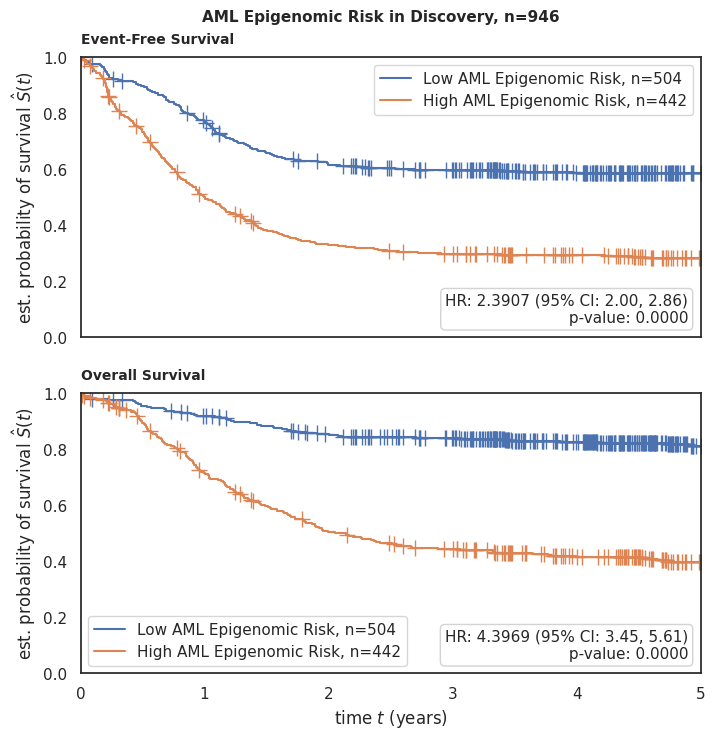

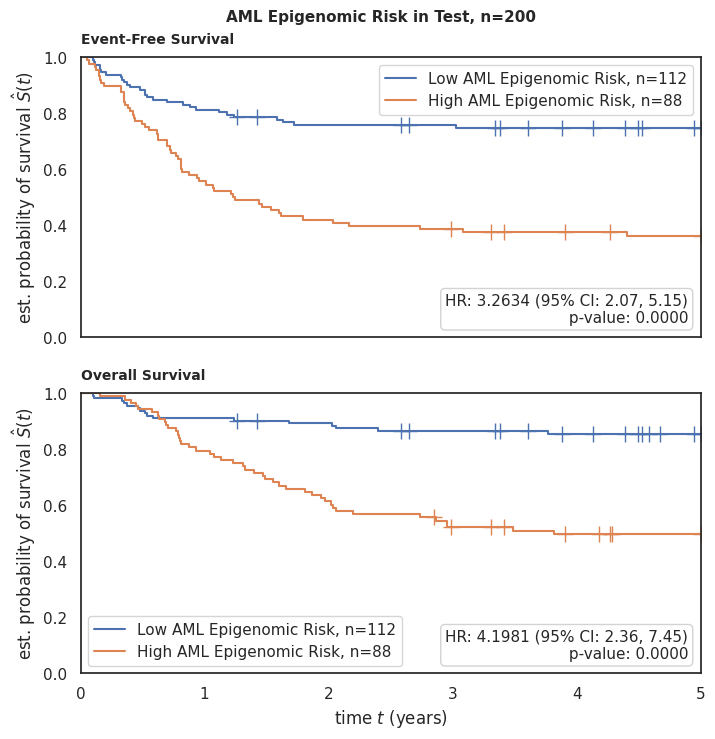

In [8]:

for dataset, trial in zip([df_px2, df_test], 
                          ['Discovery', 'Test']):
    draw_kaplan_meier(model_name=model_name2,
                        df=dataset,
                        save_survival_table=False,
                        save_plot=False,
                        show_ci=False,
                        add_risk_counts=False,
                        trialname=trial,
                        figsize=(8,8))

38CpG-AMLsignature

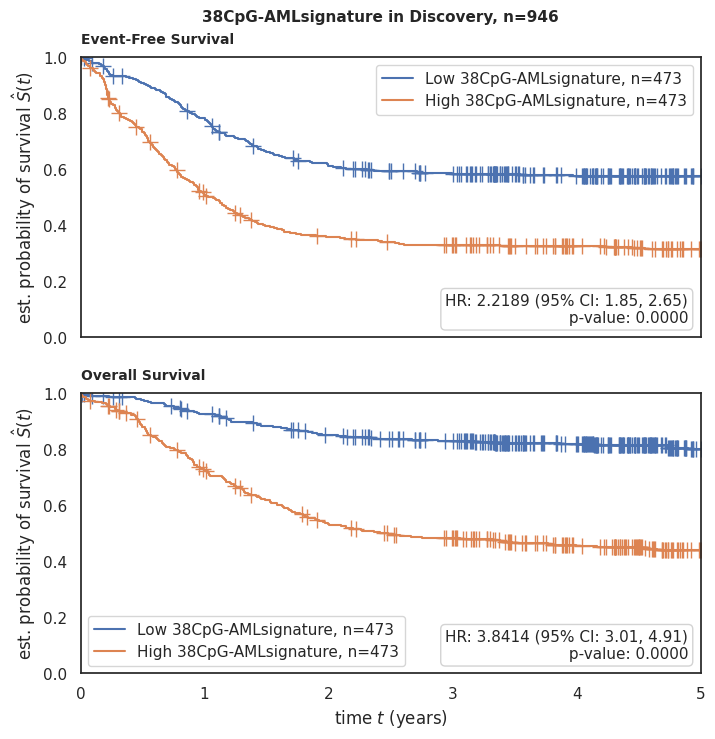

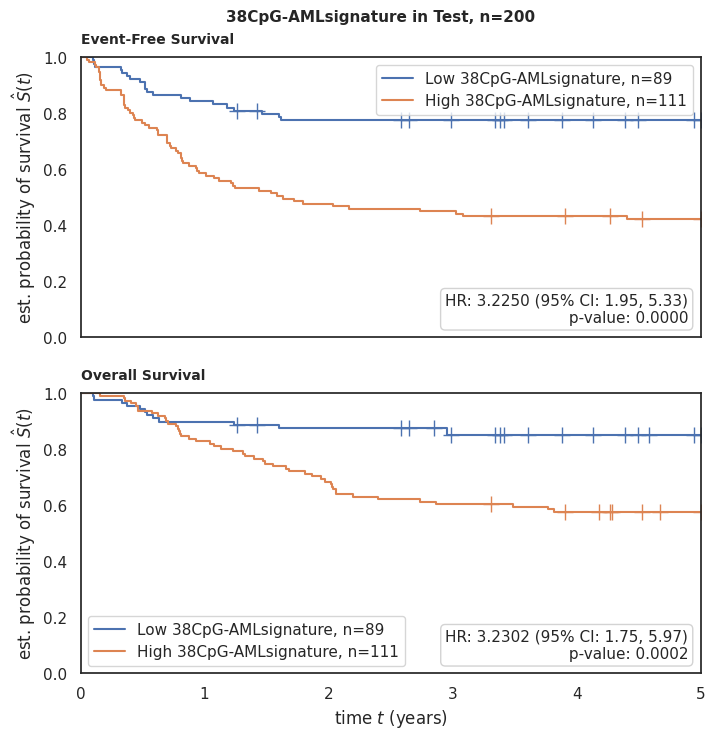

In [9]:
for dataset, trial in zip([df_px2, df_test], 
                          ['Discovery', 'Test']):

    draw_kaplan_meier(model_name=model_name3,
                        df=dataset,
                        save_survival_table=False,
                        save_plot=False,
                        show_ci=False,
                        add_risk_counts=False,
                        trialname=trial,
                        figsize=(8,8))

### Per risk group

AML Epigenomic Risk

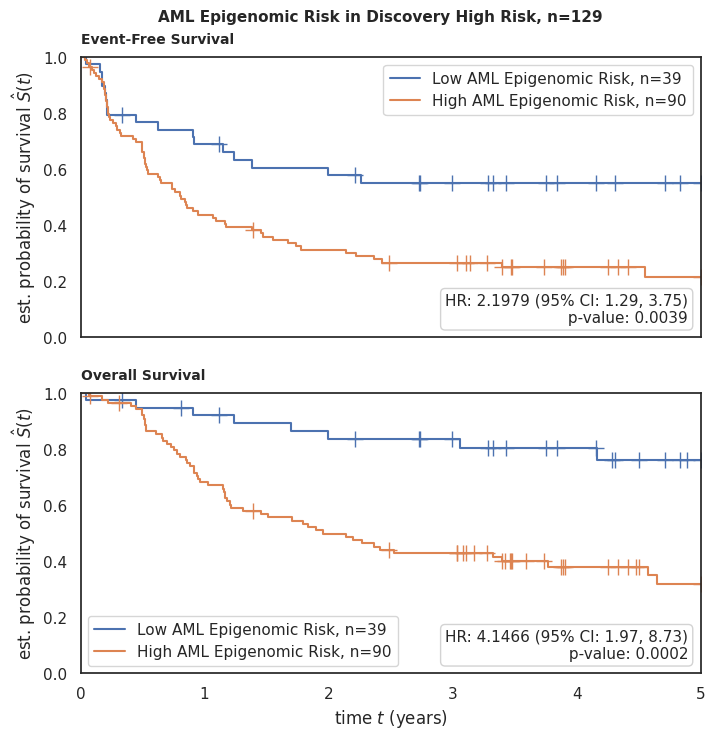

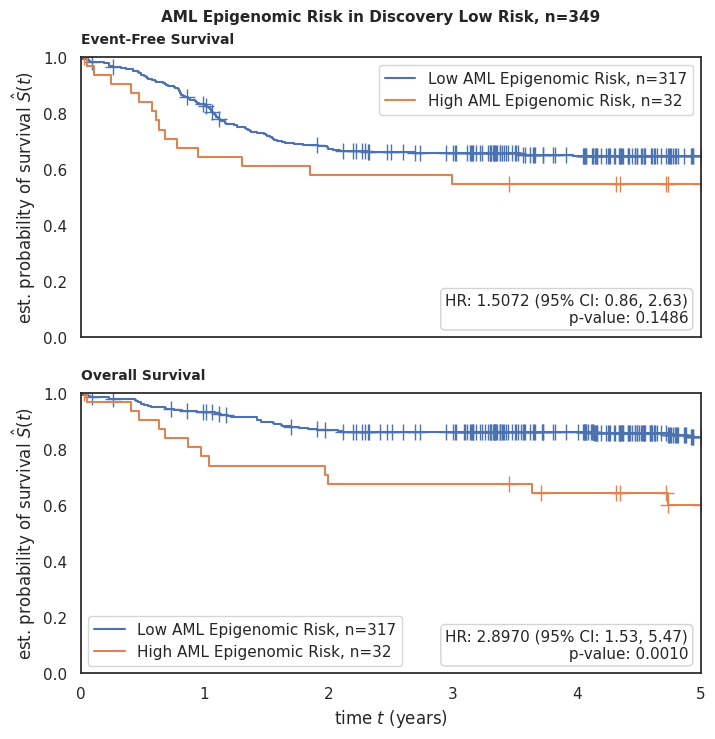

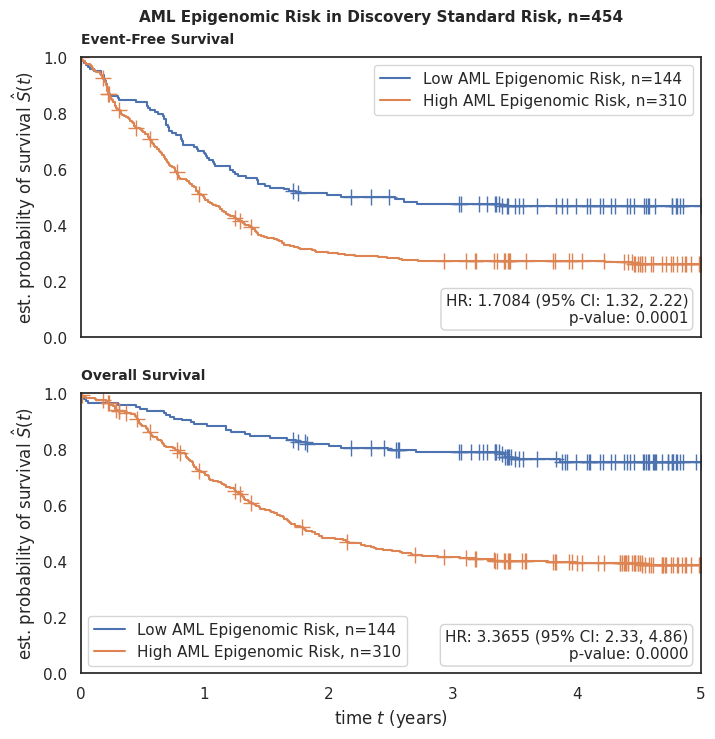

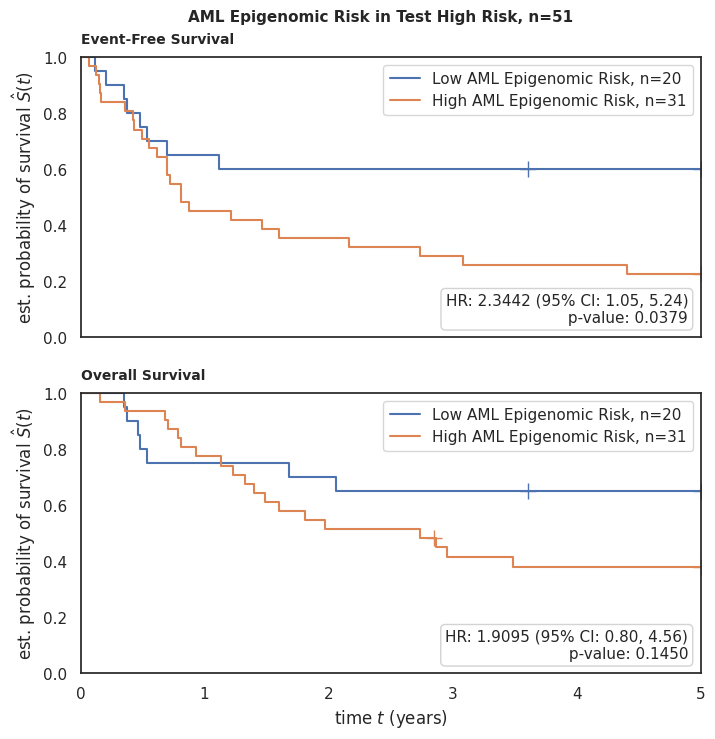

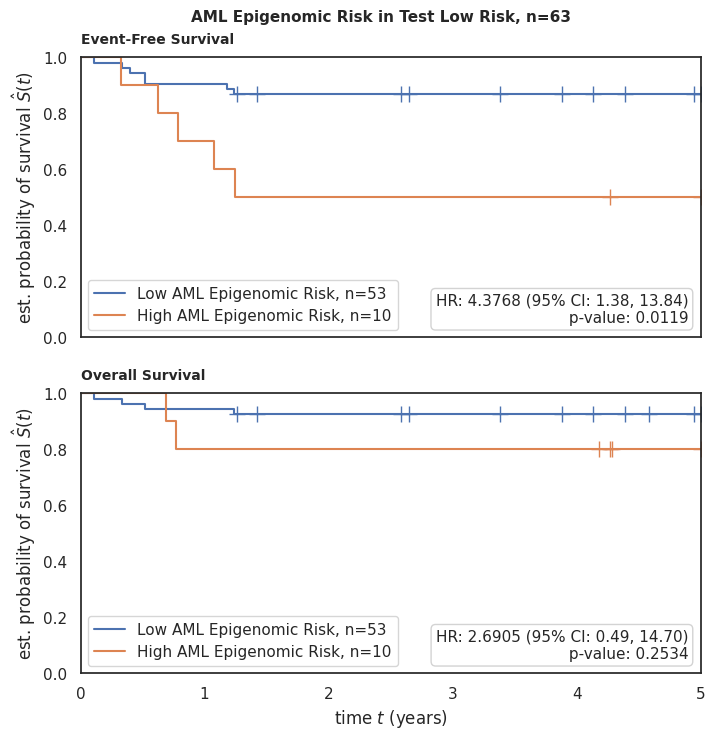

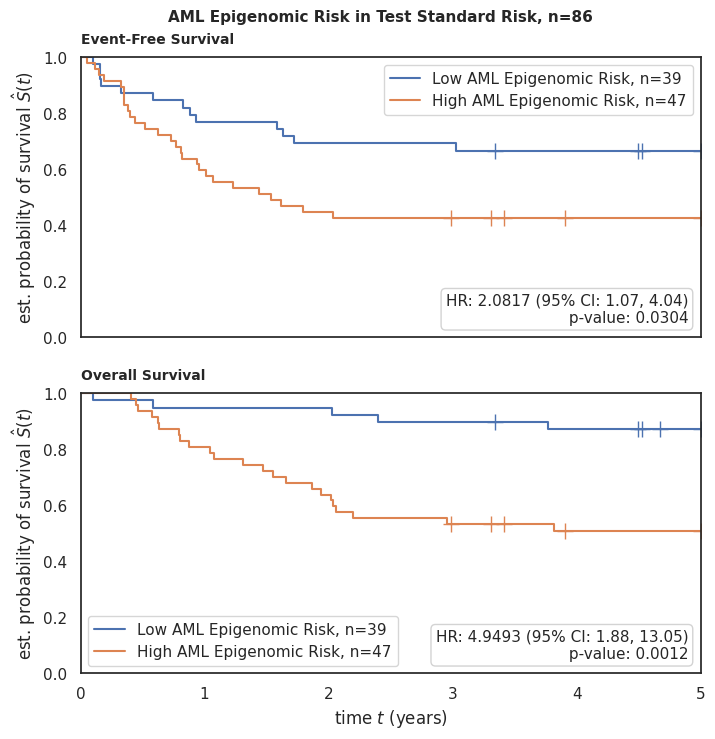

In [10]:
for dataset, trial in zip([df_px2, df_test], ['Discovery', 'Test']):

    risk_groups = ['High Risk', 'Low Risk', 'Standard Risk']
    for risk_group in risk_groups:
        draw_kaplan_meier(
            model_name=model_name2,
            df=dataset[dataset['Risk Group'] == risk_group],
            save_plot=False,
            save_survival_table=False,
            add_risk_counts=False,
            trialname=f'{trial} {risk_group}',
            figsize=(8, 8))


38CpG-AMLsignature

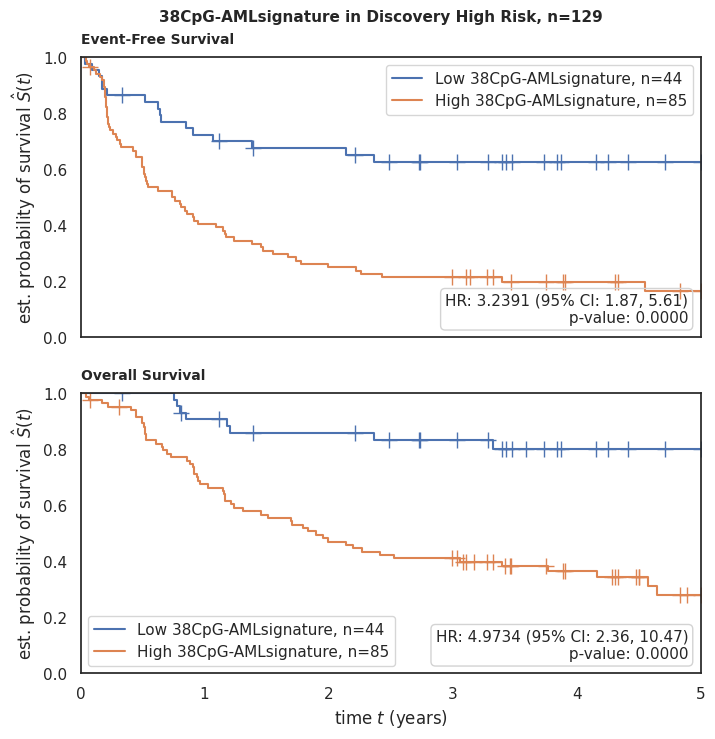

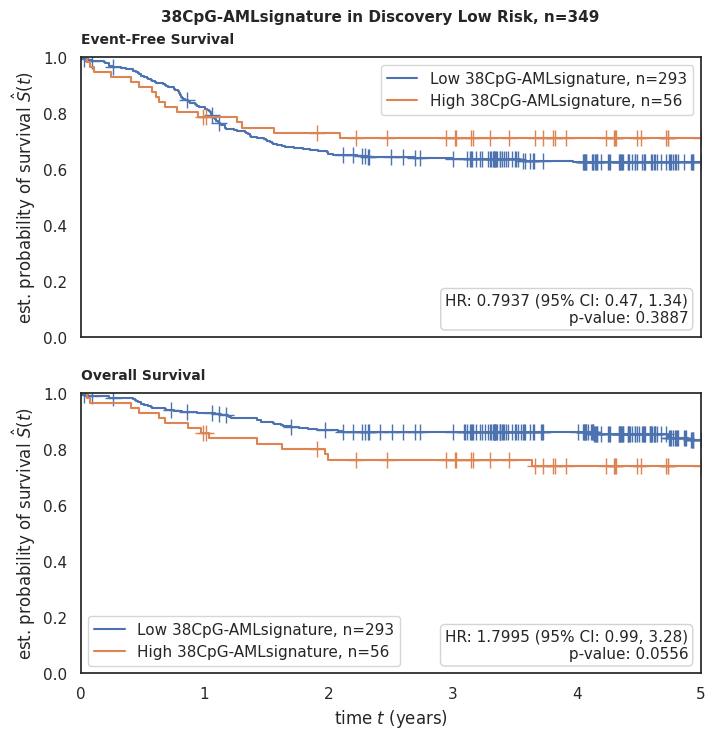

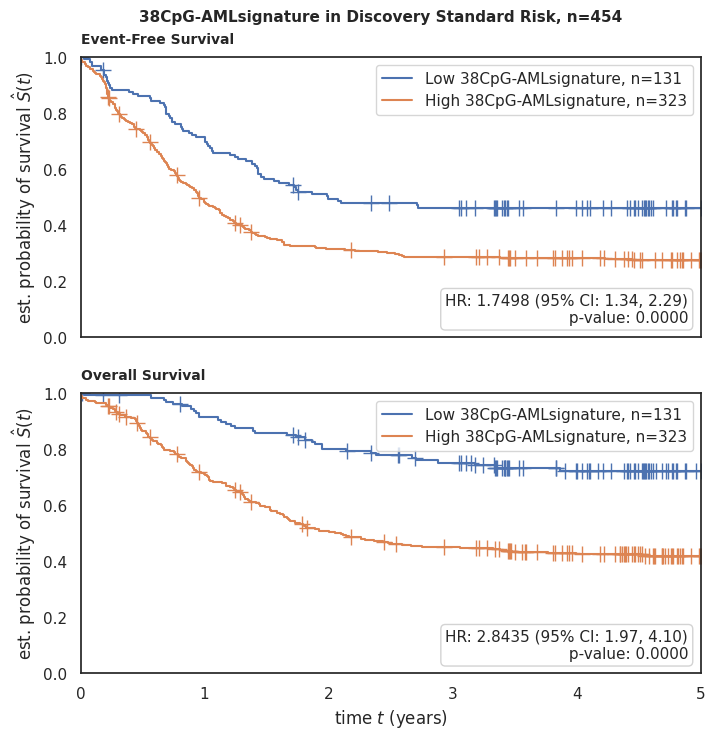

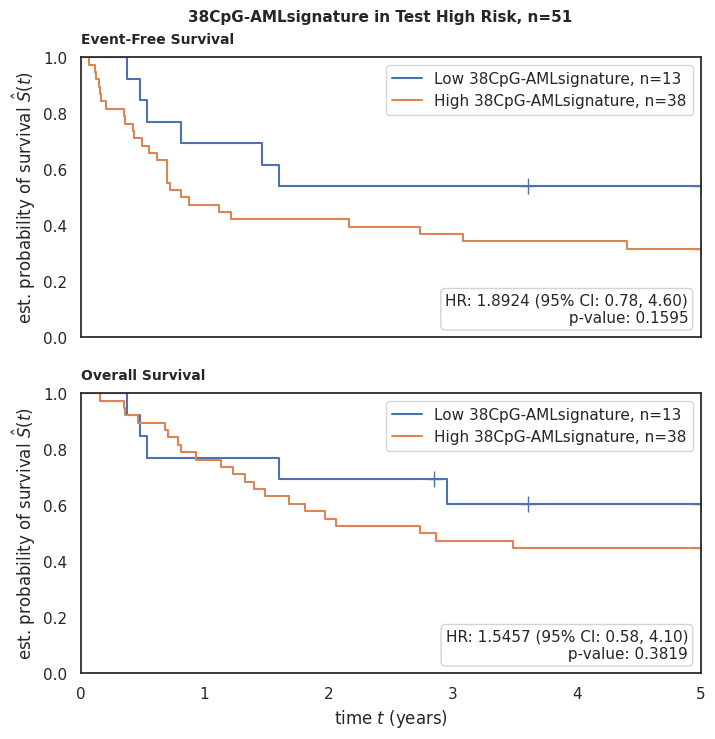

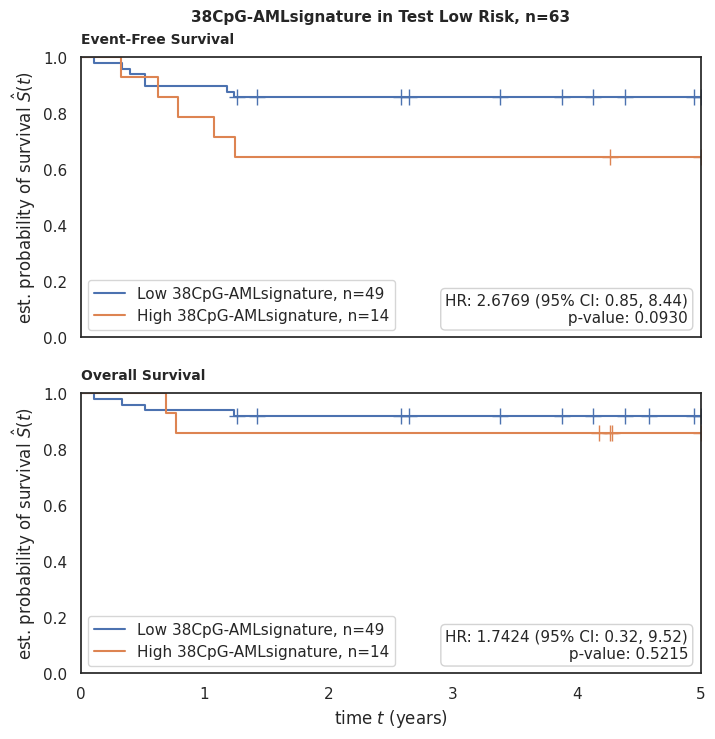

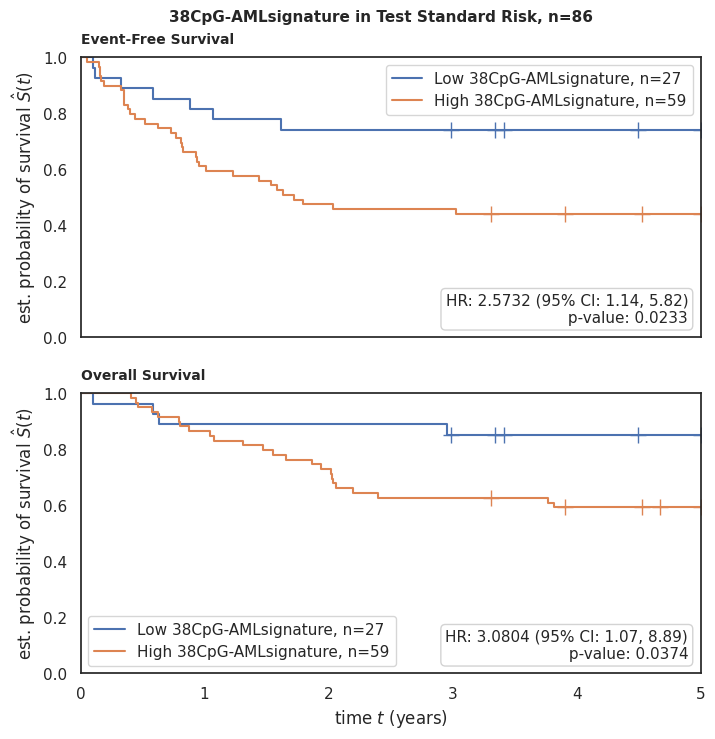

In [11]:
for dataset, trial in zip([df_px2, df_test], ['Discovery', 'Test']):

    risk_groups = ['High Risk', 'Low Risk', 'Standard Risk']
    for risk_group in risk_groups:
        draw_kaplan_meier(
            model_name= model_name3,
            df=dataset[dataset['Risk Group'] == risk_group],
            save_plot=False,
            save_survival_table=False,
            add_risk_counts=False,
            trialname=f'{trial} {risk_group}',
            figsize=(8, 8))

### Per risk group (AAML1831 COG)

AML Epigenomic Risk

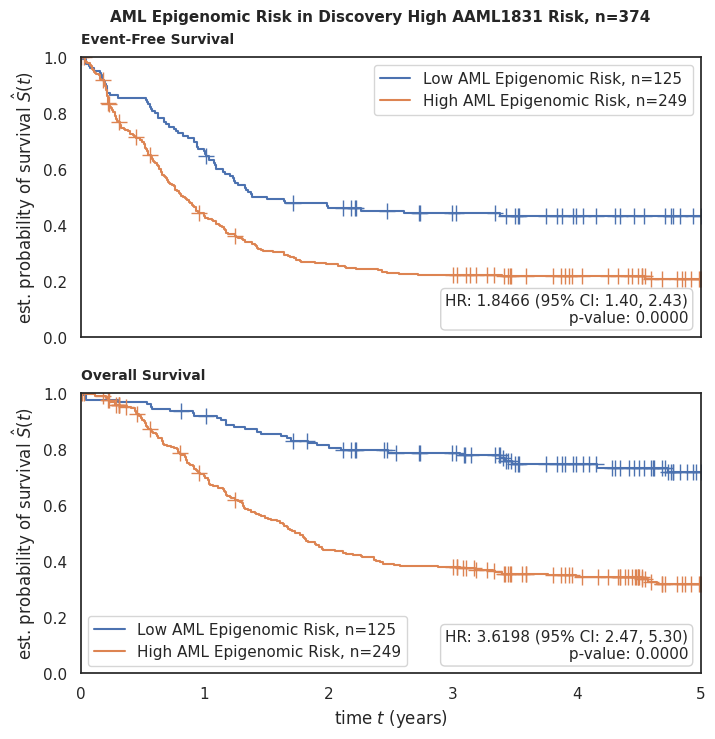

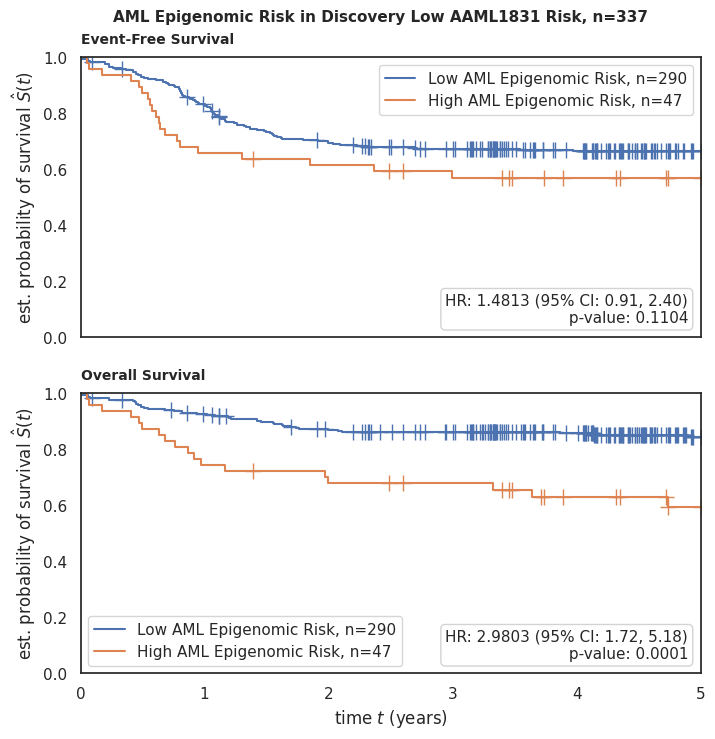

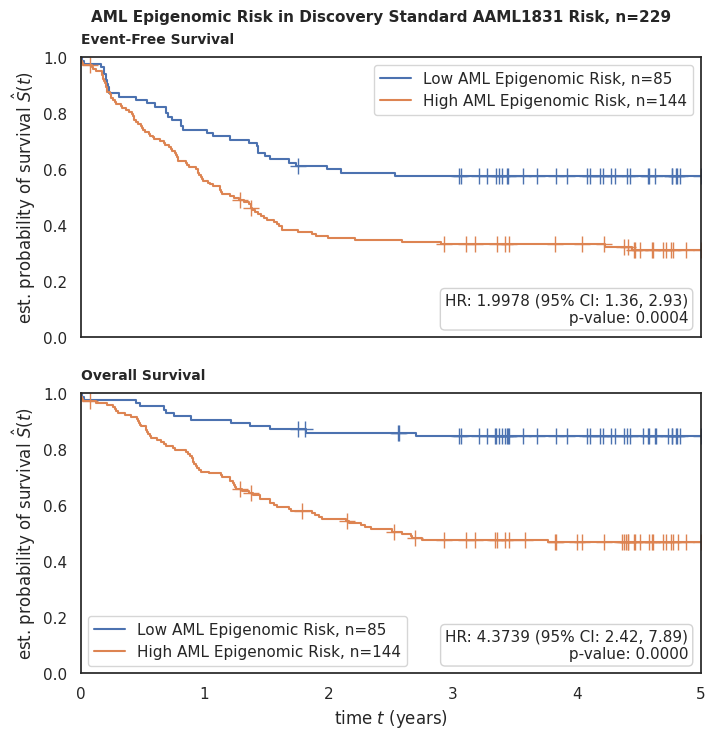

In [12]:
for dataset, trial in zip([df_px2],['Discovery']):

    risk_groups = ['High', 'Low', 'Standard']
    for risk_group in risk_groups:
        draw_kaplan_meier(
            model_name=model_name2,
            df=dataset[dataset['Risk Group AAML1831'] == risk_group],
            save_plot=False,
            save_survival_table=False,
            add_risk_counts=False,
            trialname=f'{trial} {risk_group} AAML1831 Risk',
            figsize=(8, 8))


38CpG-AMLsignature

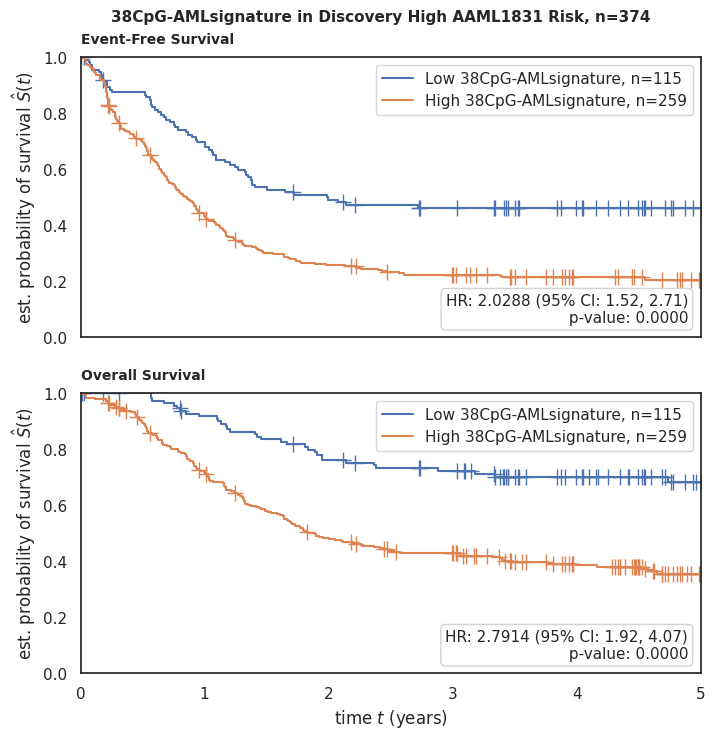

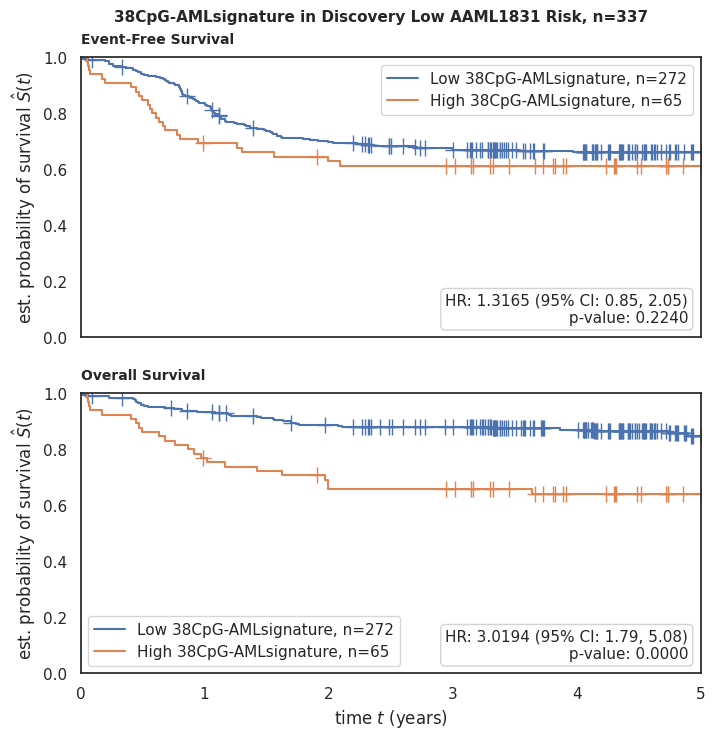

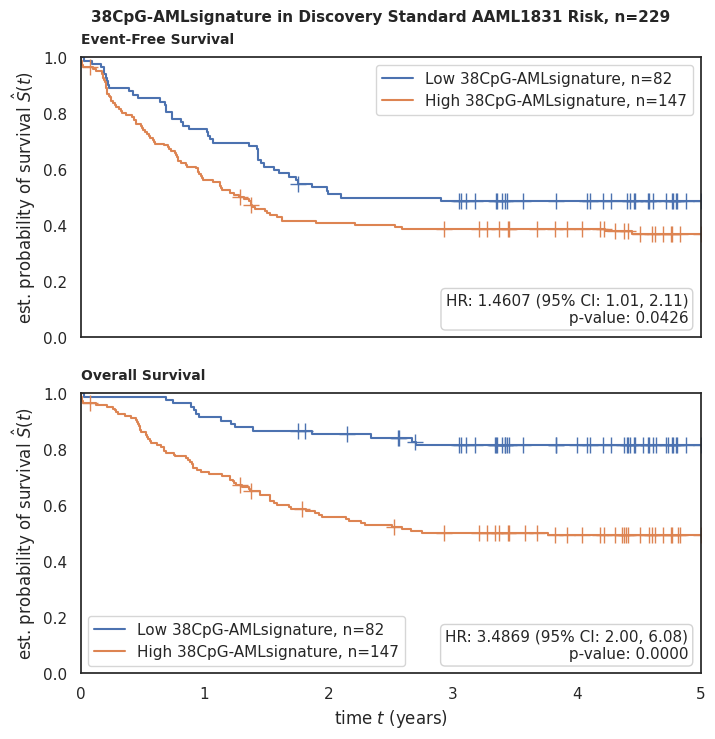

In [13]:
for dataset, trial in zip([df_px2],['Discovery']):

    risk_groups = ['High', 'Low', 'Standard']
    for risk_group in risk_groups:
        draw_kaplan_meier(
            model_name=model_name3,
            df=dataset[dataset['Risk Group AAML1831'] == risk_group],
            save_plot=False,
            save_survival_table=False,
            add_risk_counts=False,
            trialname=f'{trial} {risk_group} AAML1831 Risk',
            figsize=(8, 8))

## Forest Plots

### With MRD 1 and BM blast (%)

AML Epigenomic Risk

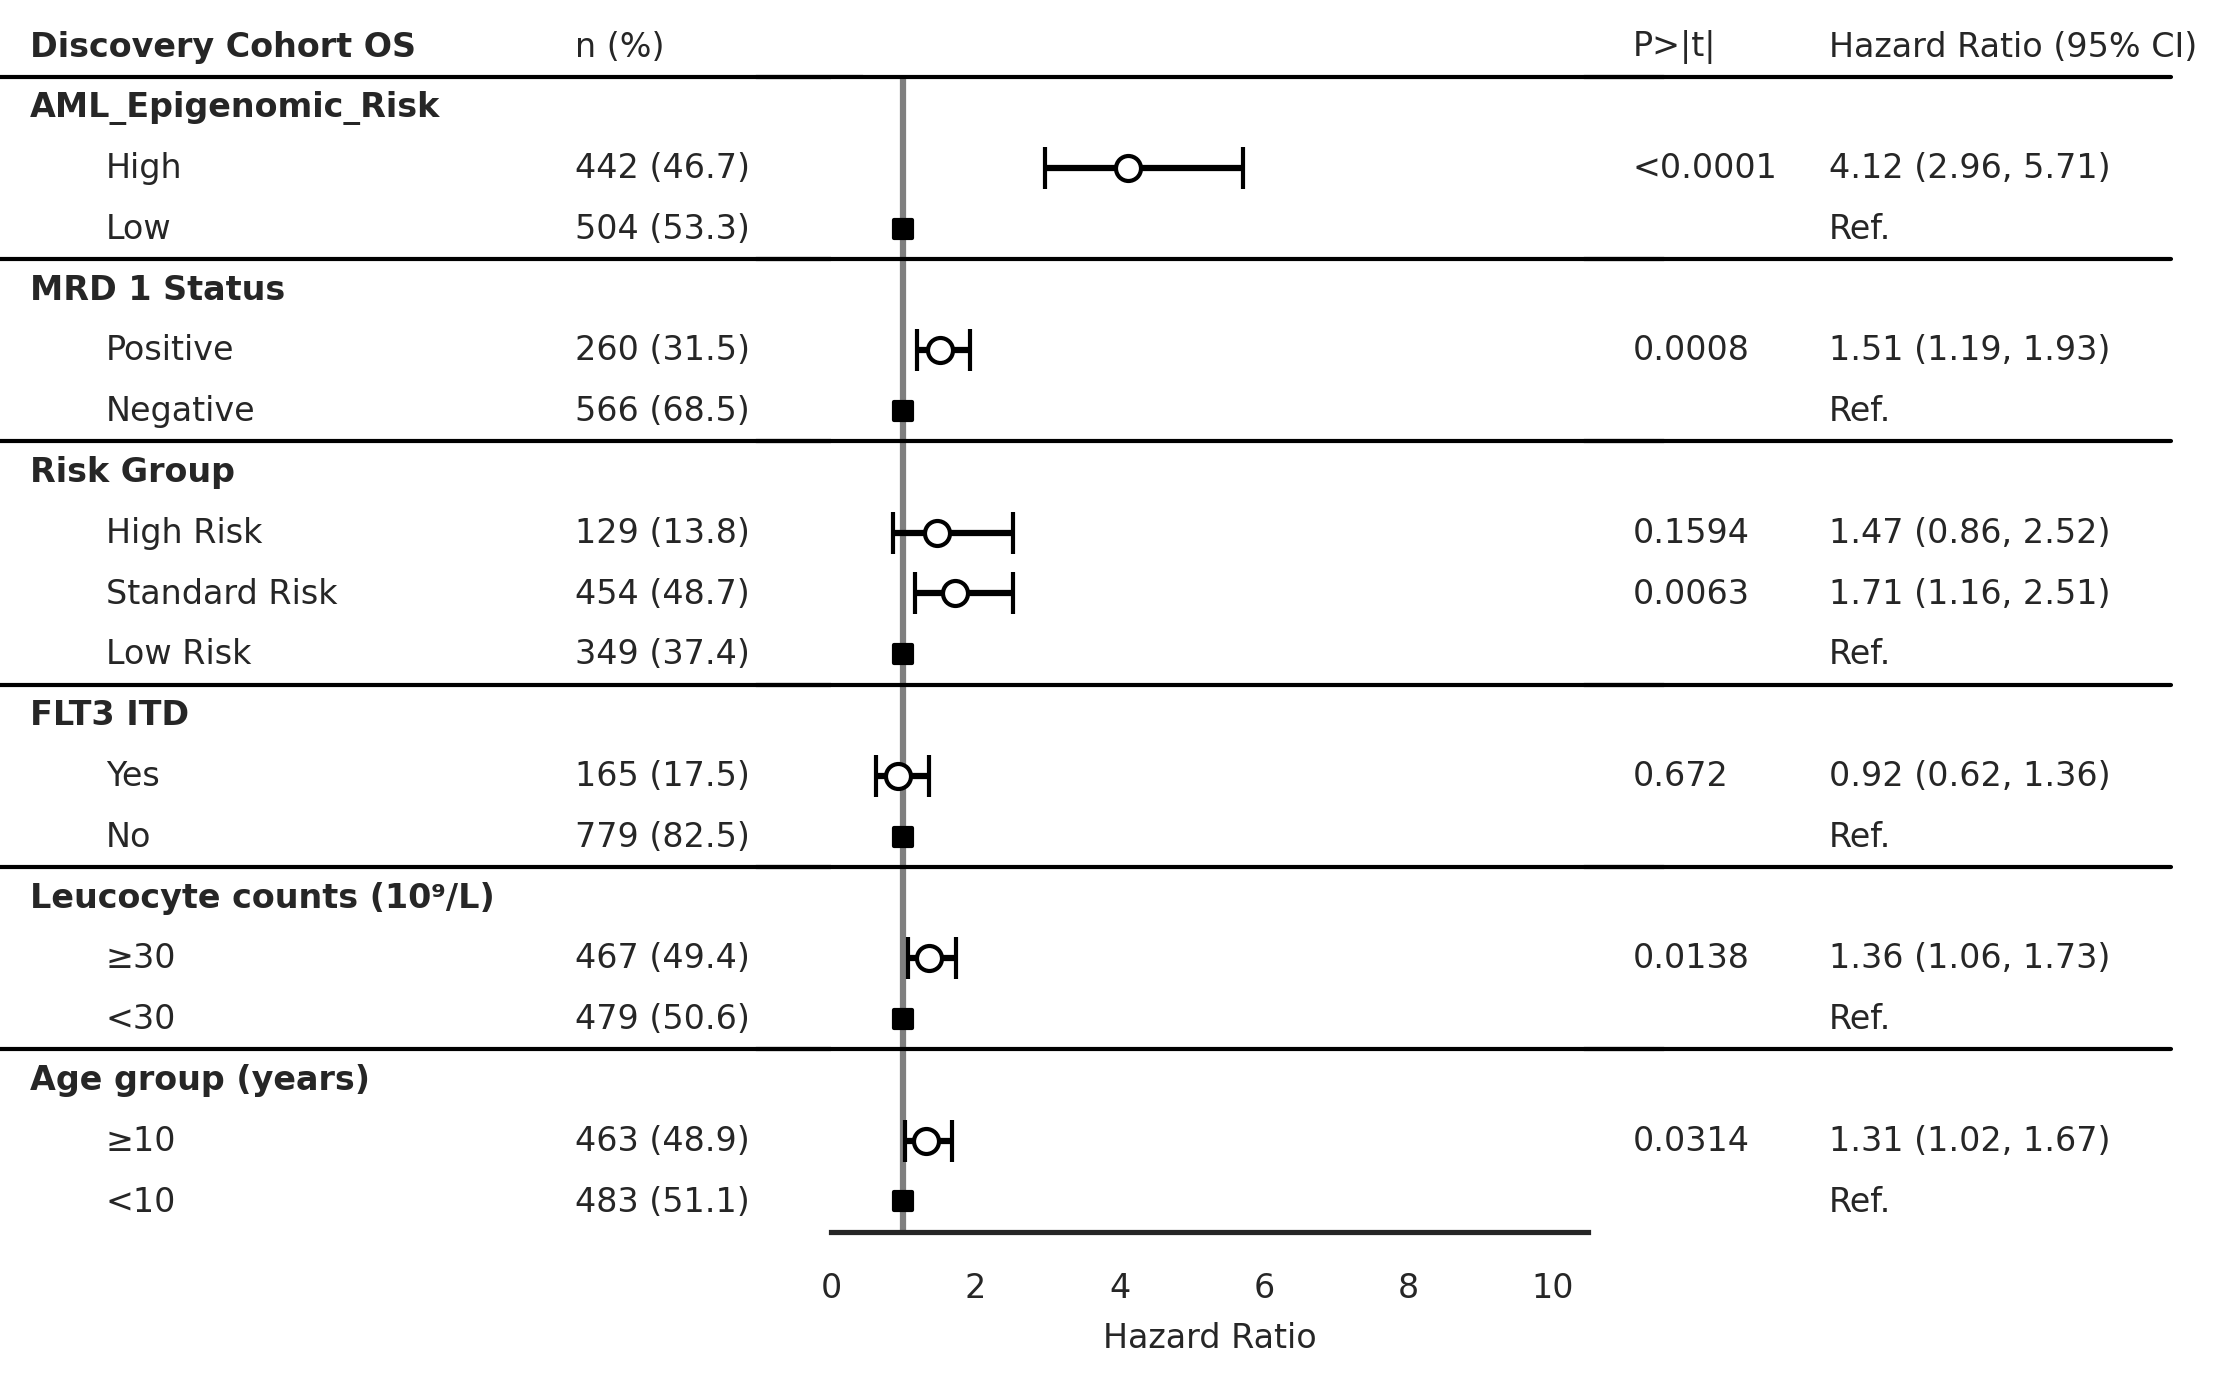

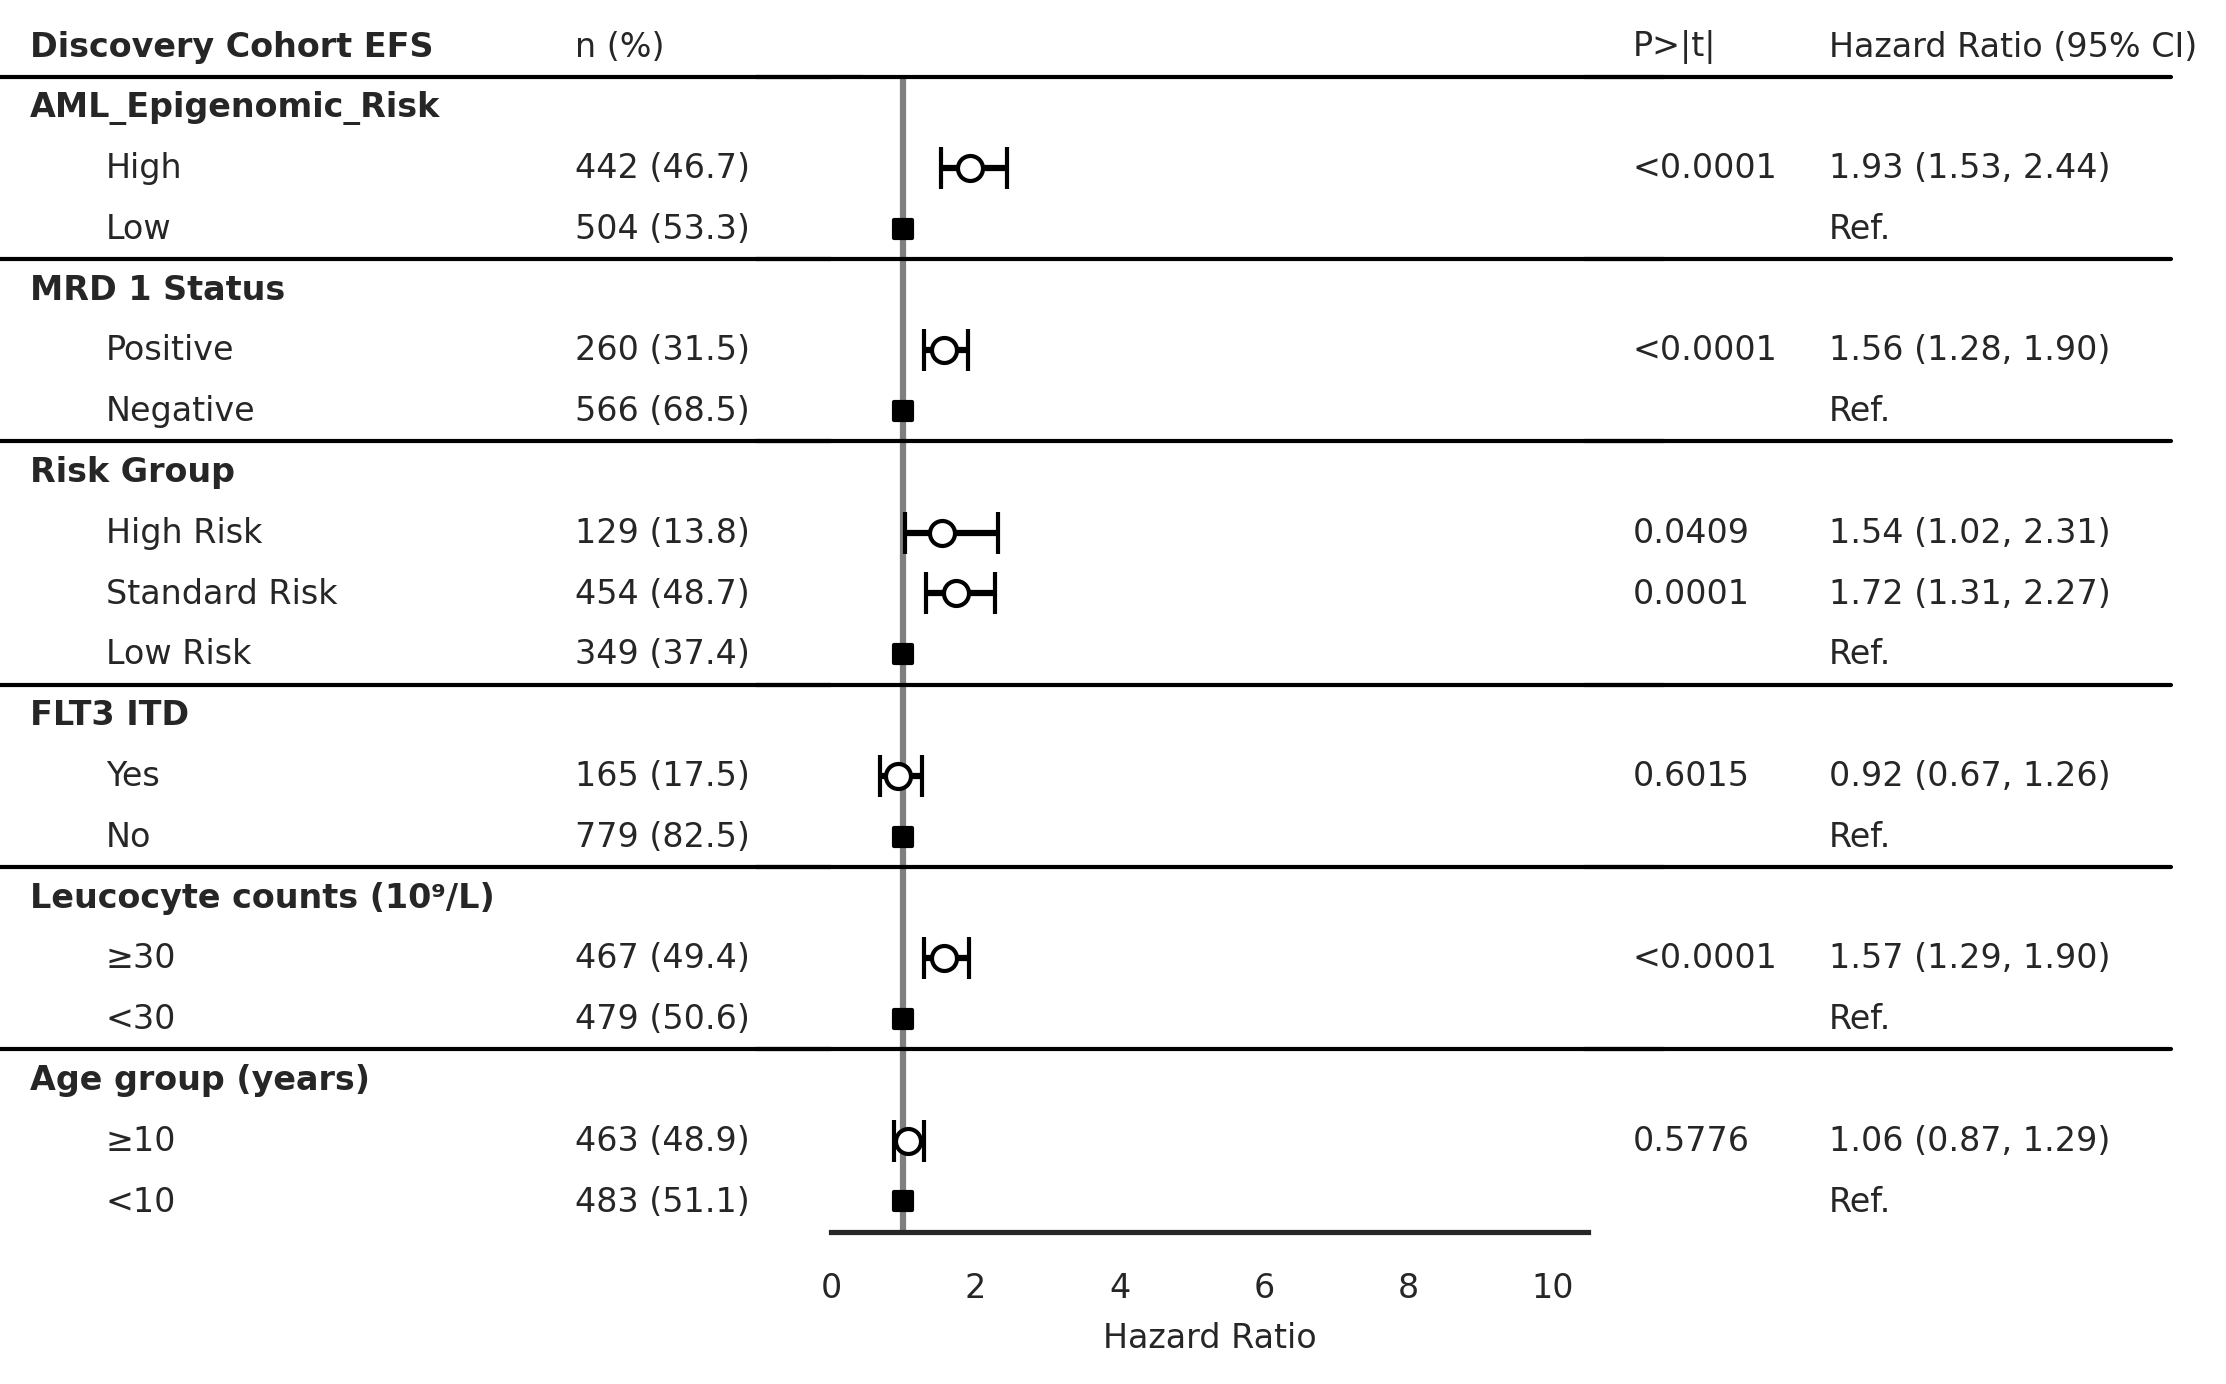

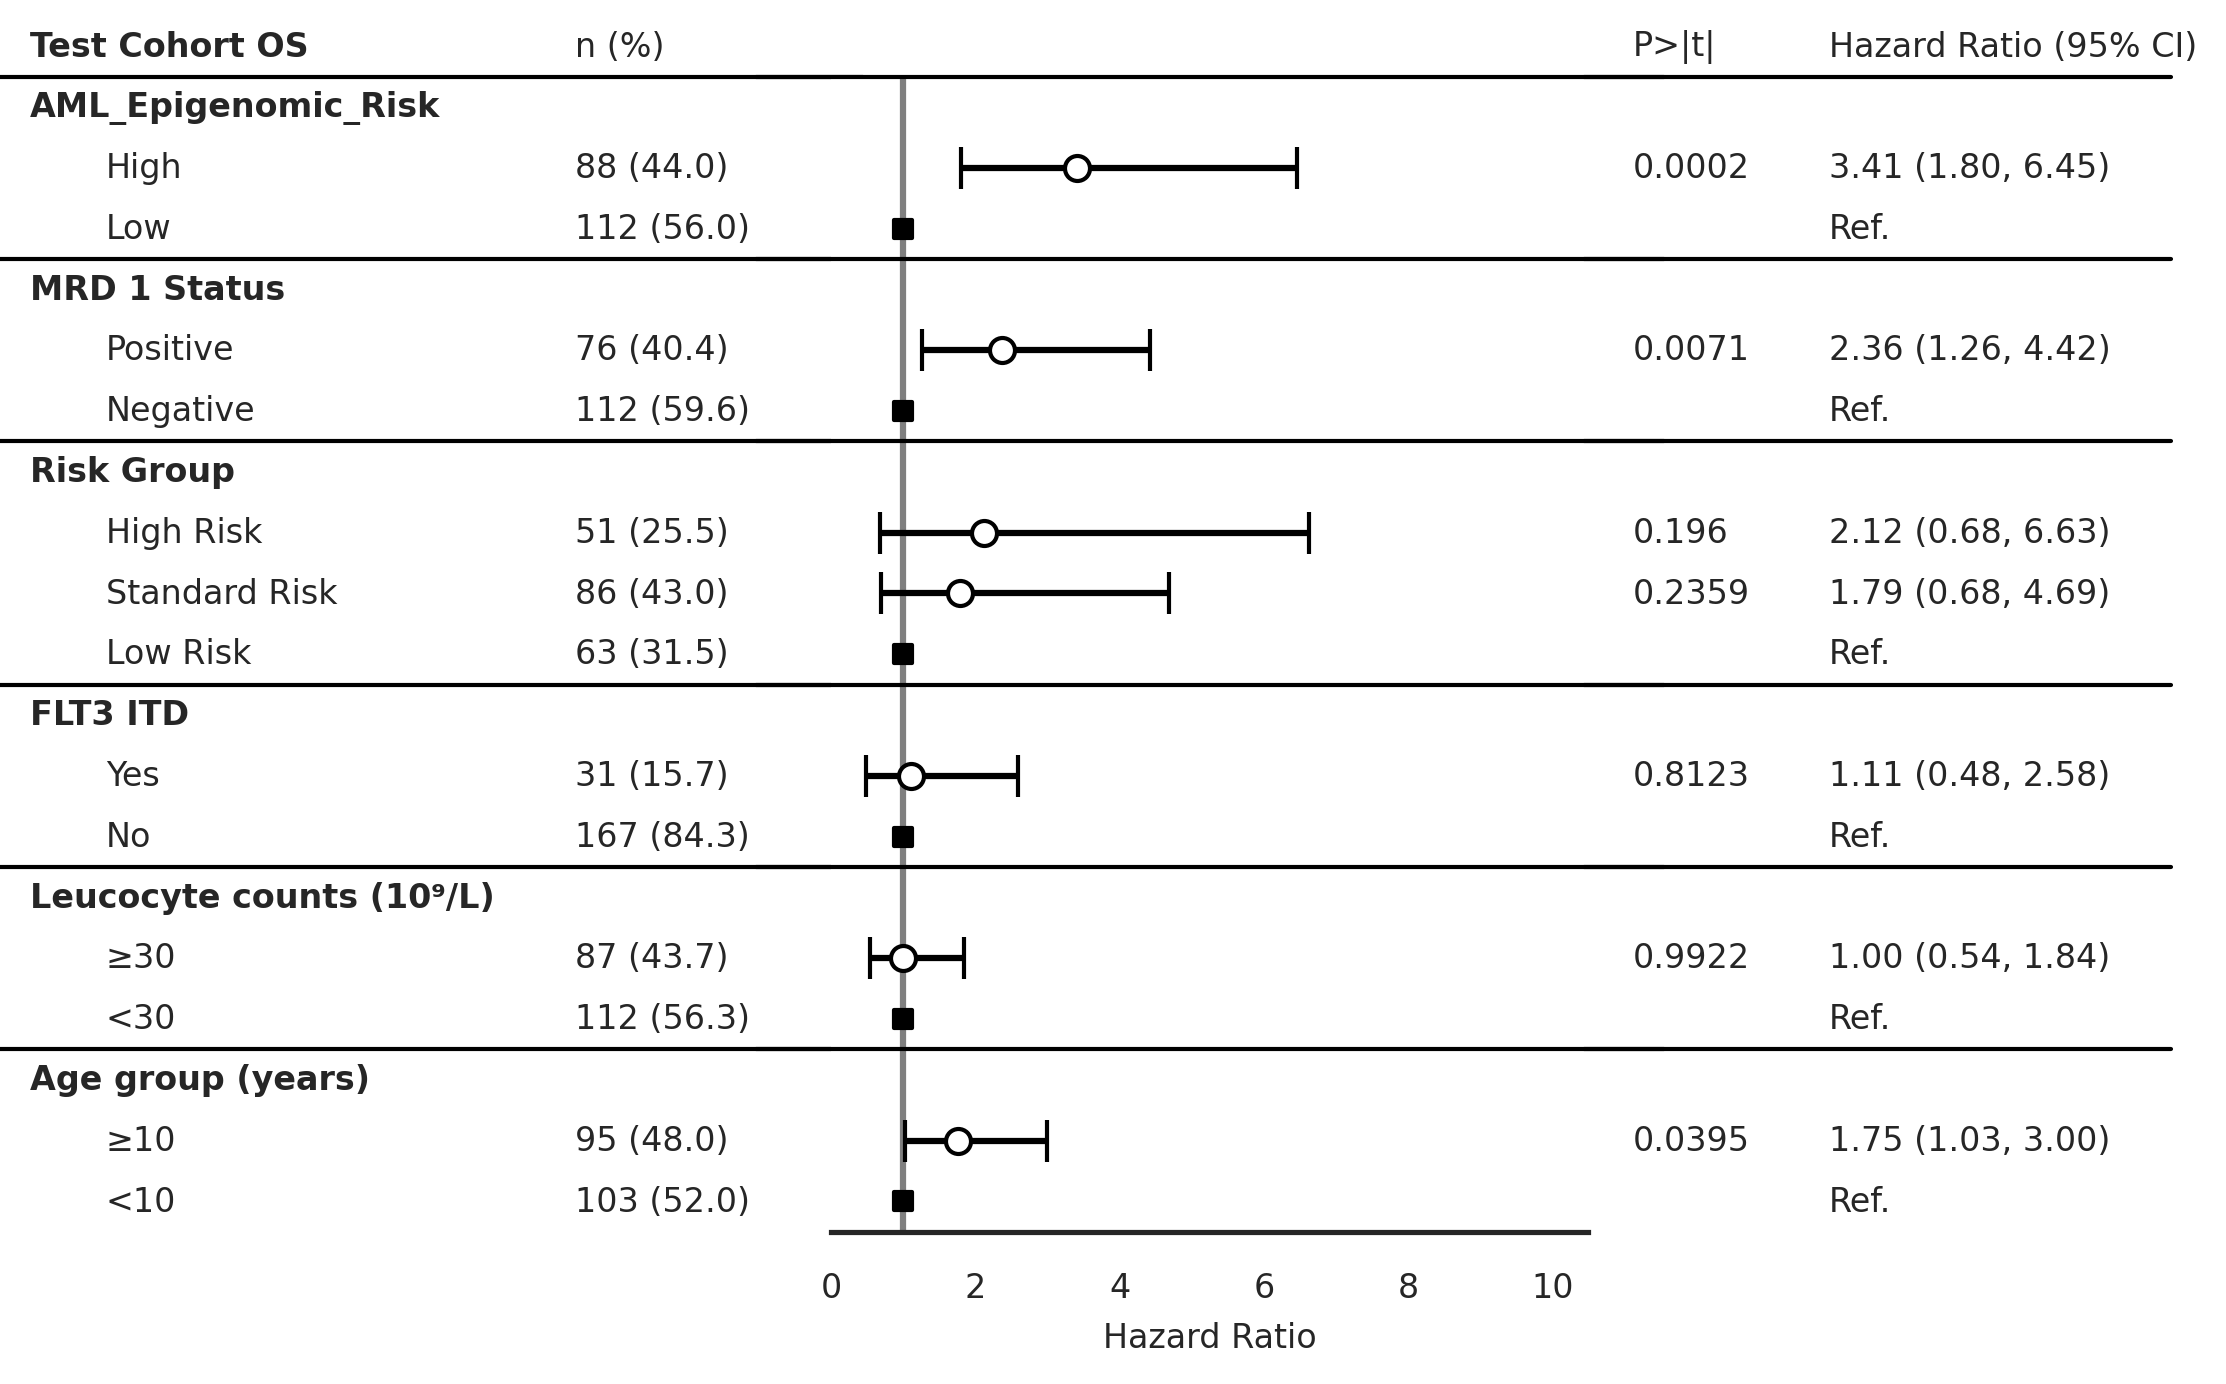

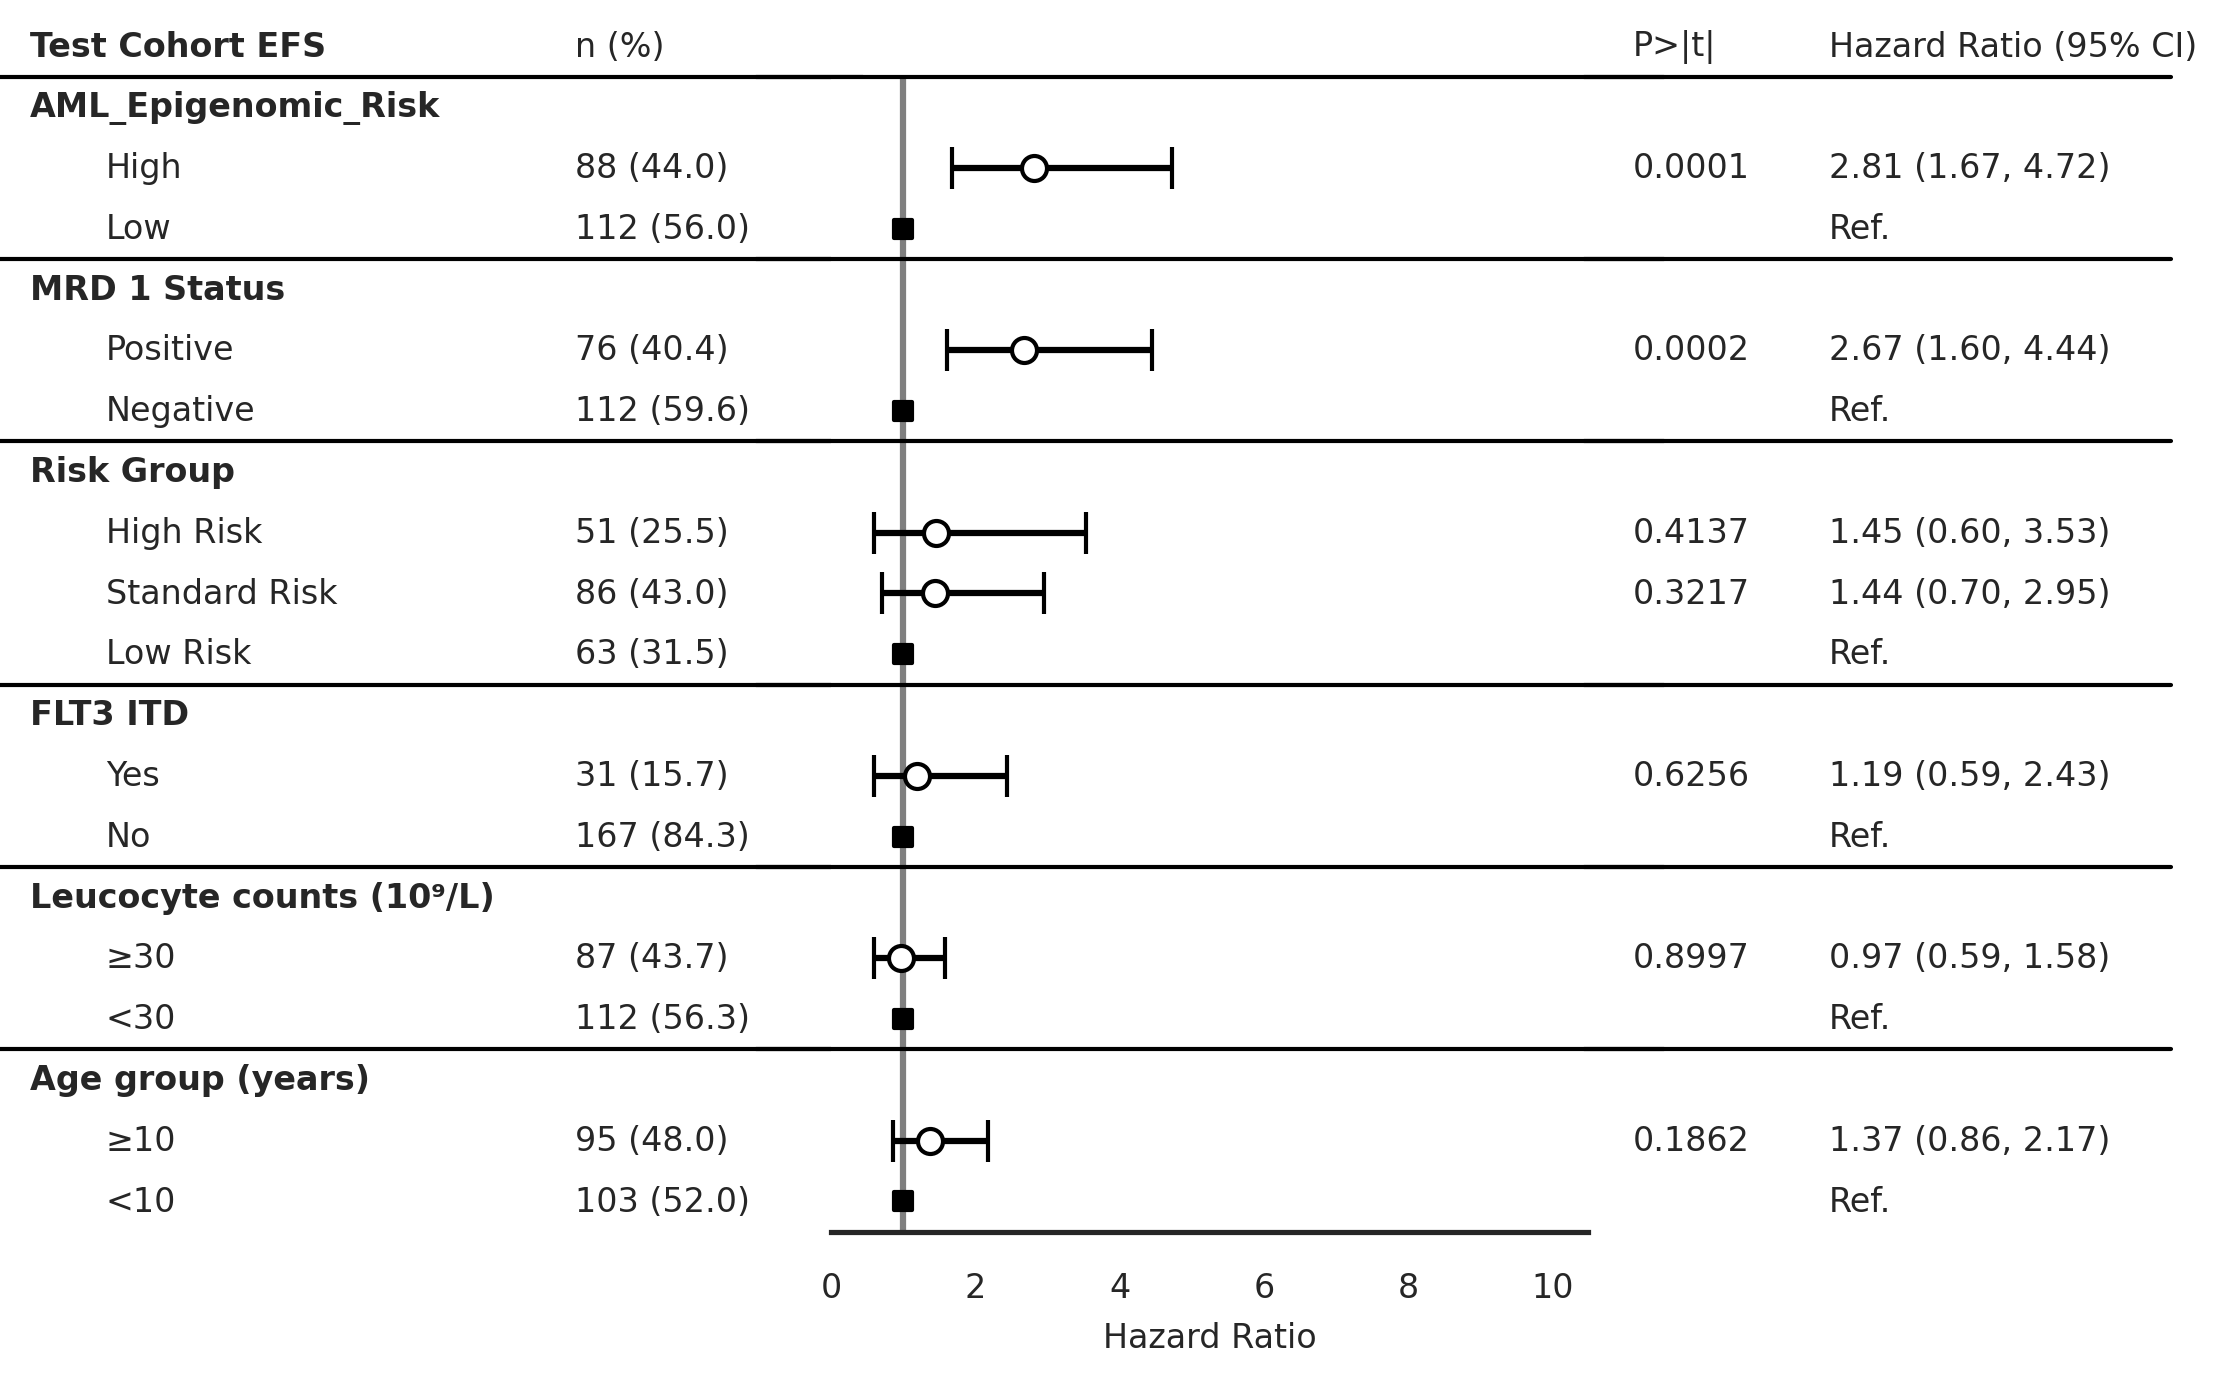

In [14]:
for dataset, trial in zip([df_px2, df_test], ['Discovery Cohort', 'Test Cohort']):
    
    df_ = dataset.copy()
    df_['BM leukemic blasts (%)'] = pd.cut(df_['BM leukemic blasts (%)'], bins=[0,50,100], labels=['≤50', '>50'])
    df_['AML_Epigenomic_Risk'] = df_[model_name2]
    df_['AMLsignature_38CpG'] = df_[model_name3]
    df_['os_time_5y'] = df_['os.time at 5y']
    df_['os_evnt_5y'] = df_['os.evnt at 5y']
    df_['efs_time_5y'] = df_['efs.time at 5y']
    df_['efs_evnt_5y'] = df_['efs.evnt at 5y']

    draw_forest_plot(time='os_time_5y',
                        event='os_evnt_5y',
                        df=df_,
                        trialname=trial,
                        model_name='AML_Epigenomic_Risk',
                        save_plot=False)

    draw_forest_plot(time='efs_time_5y',
                        event='efs_evnt_5y',
                        df=df_,
                        trialname=trial,
                        model_name='AML_Epigenomic_Risk',
                        save_plot=False)


38CpG-AMLsignature

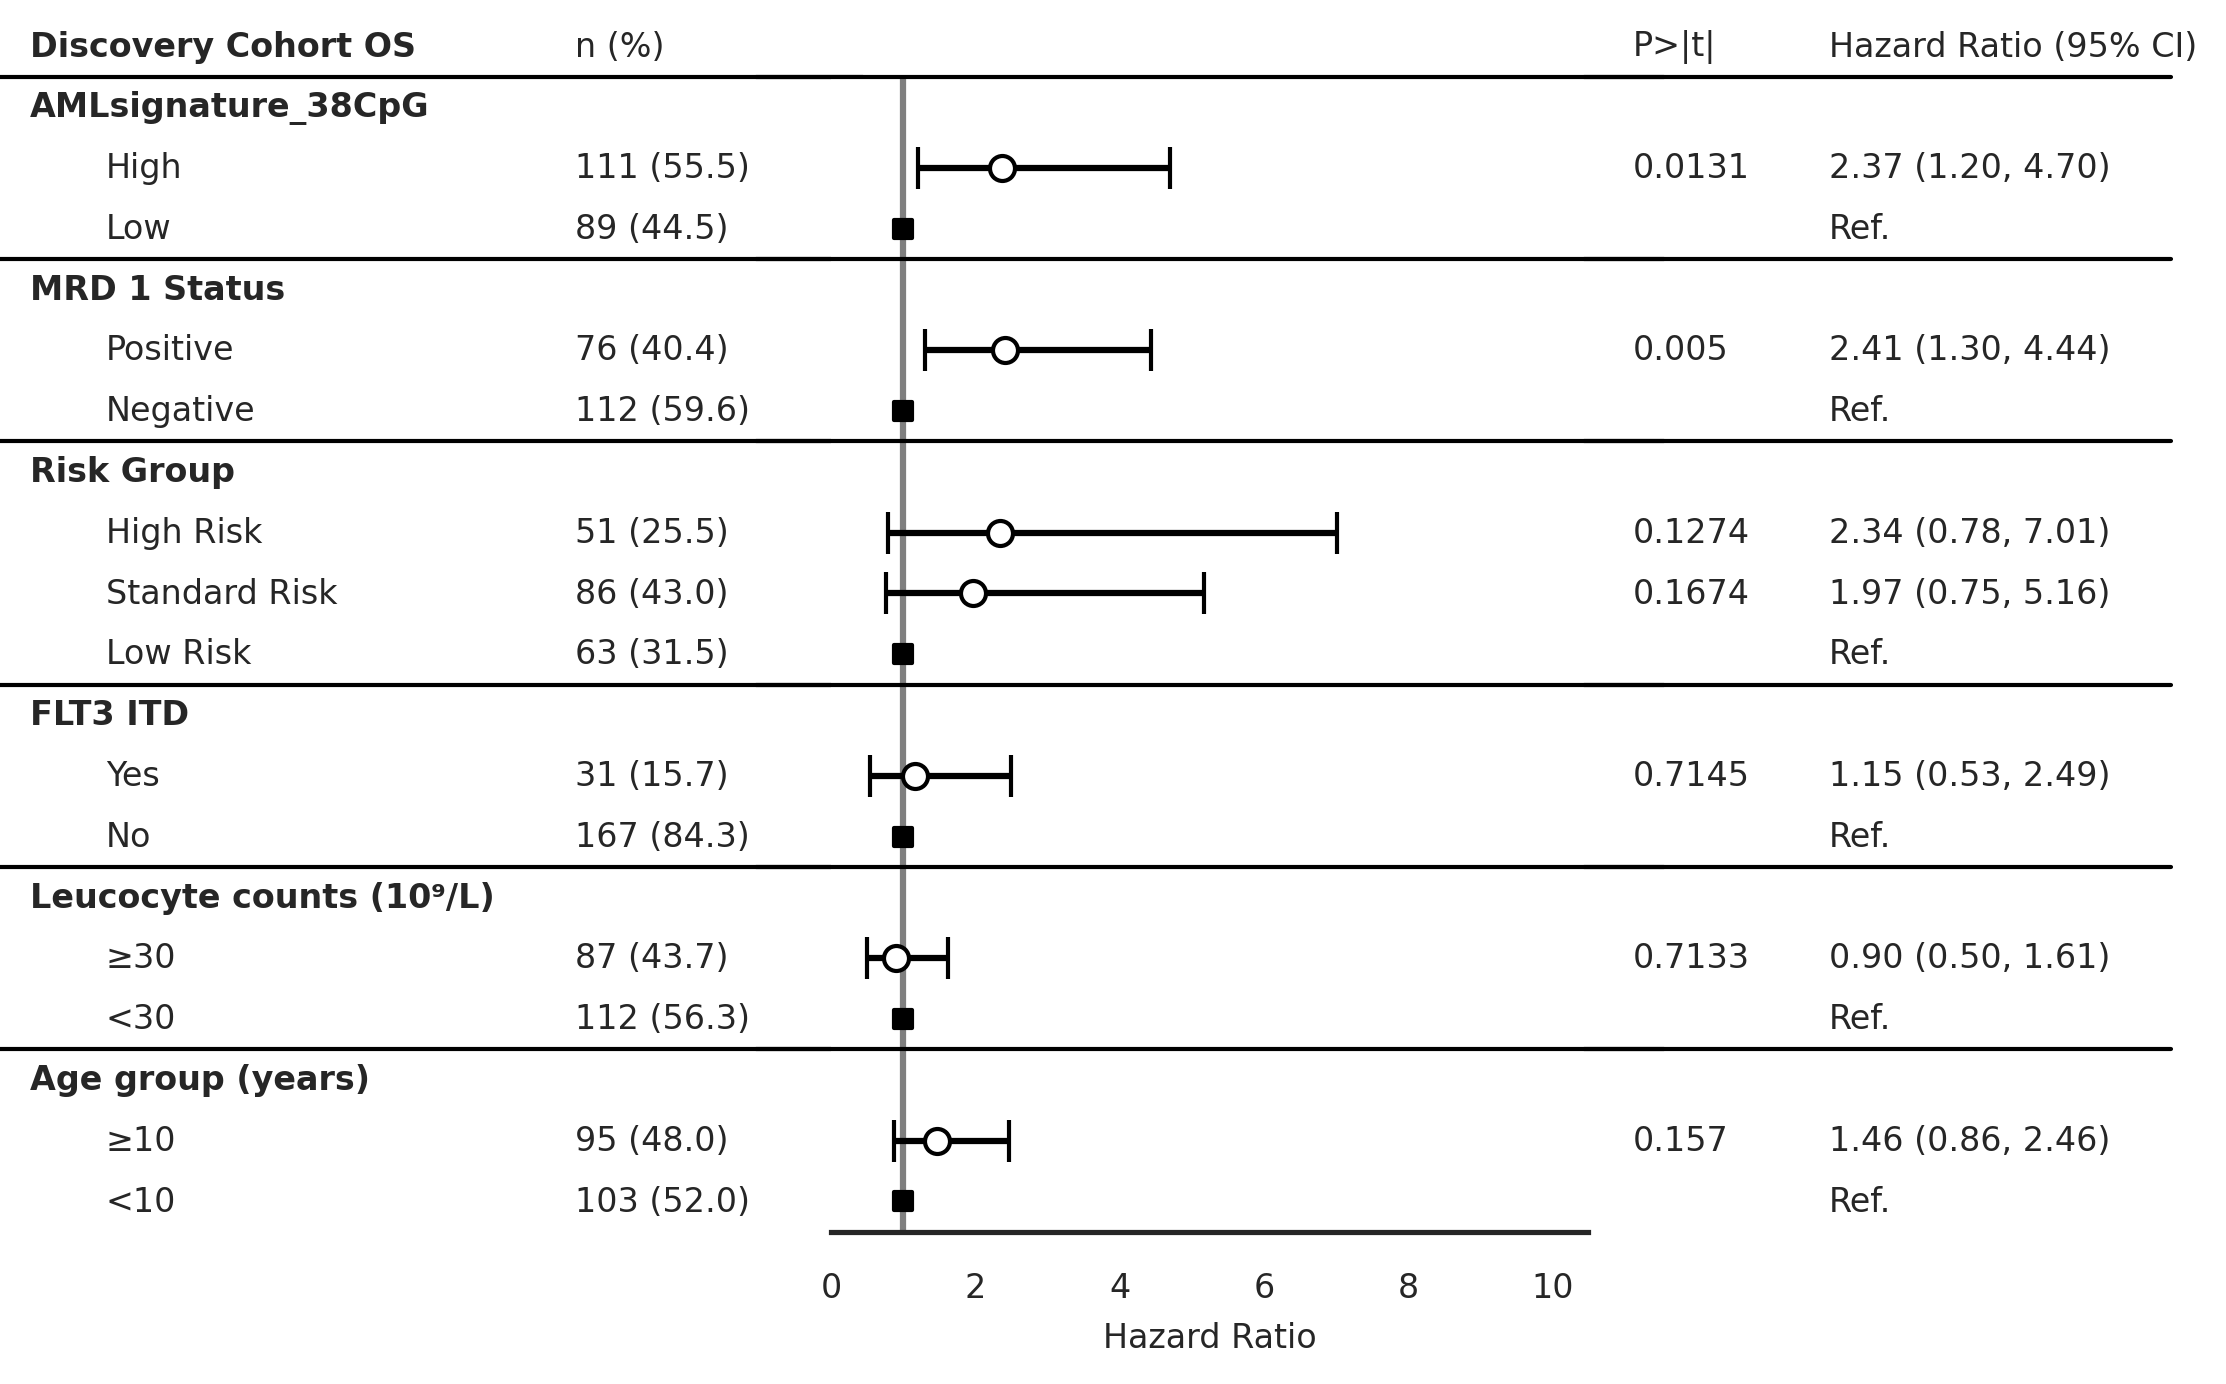

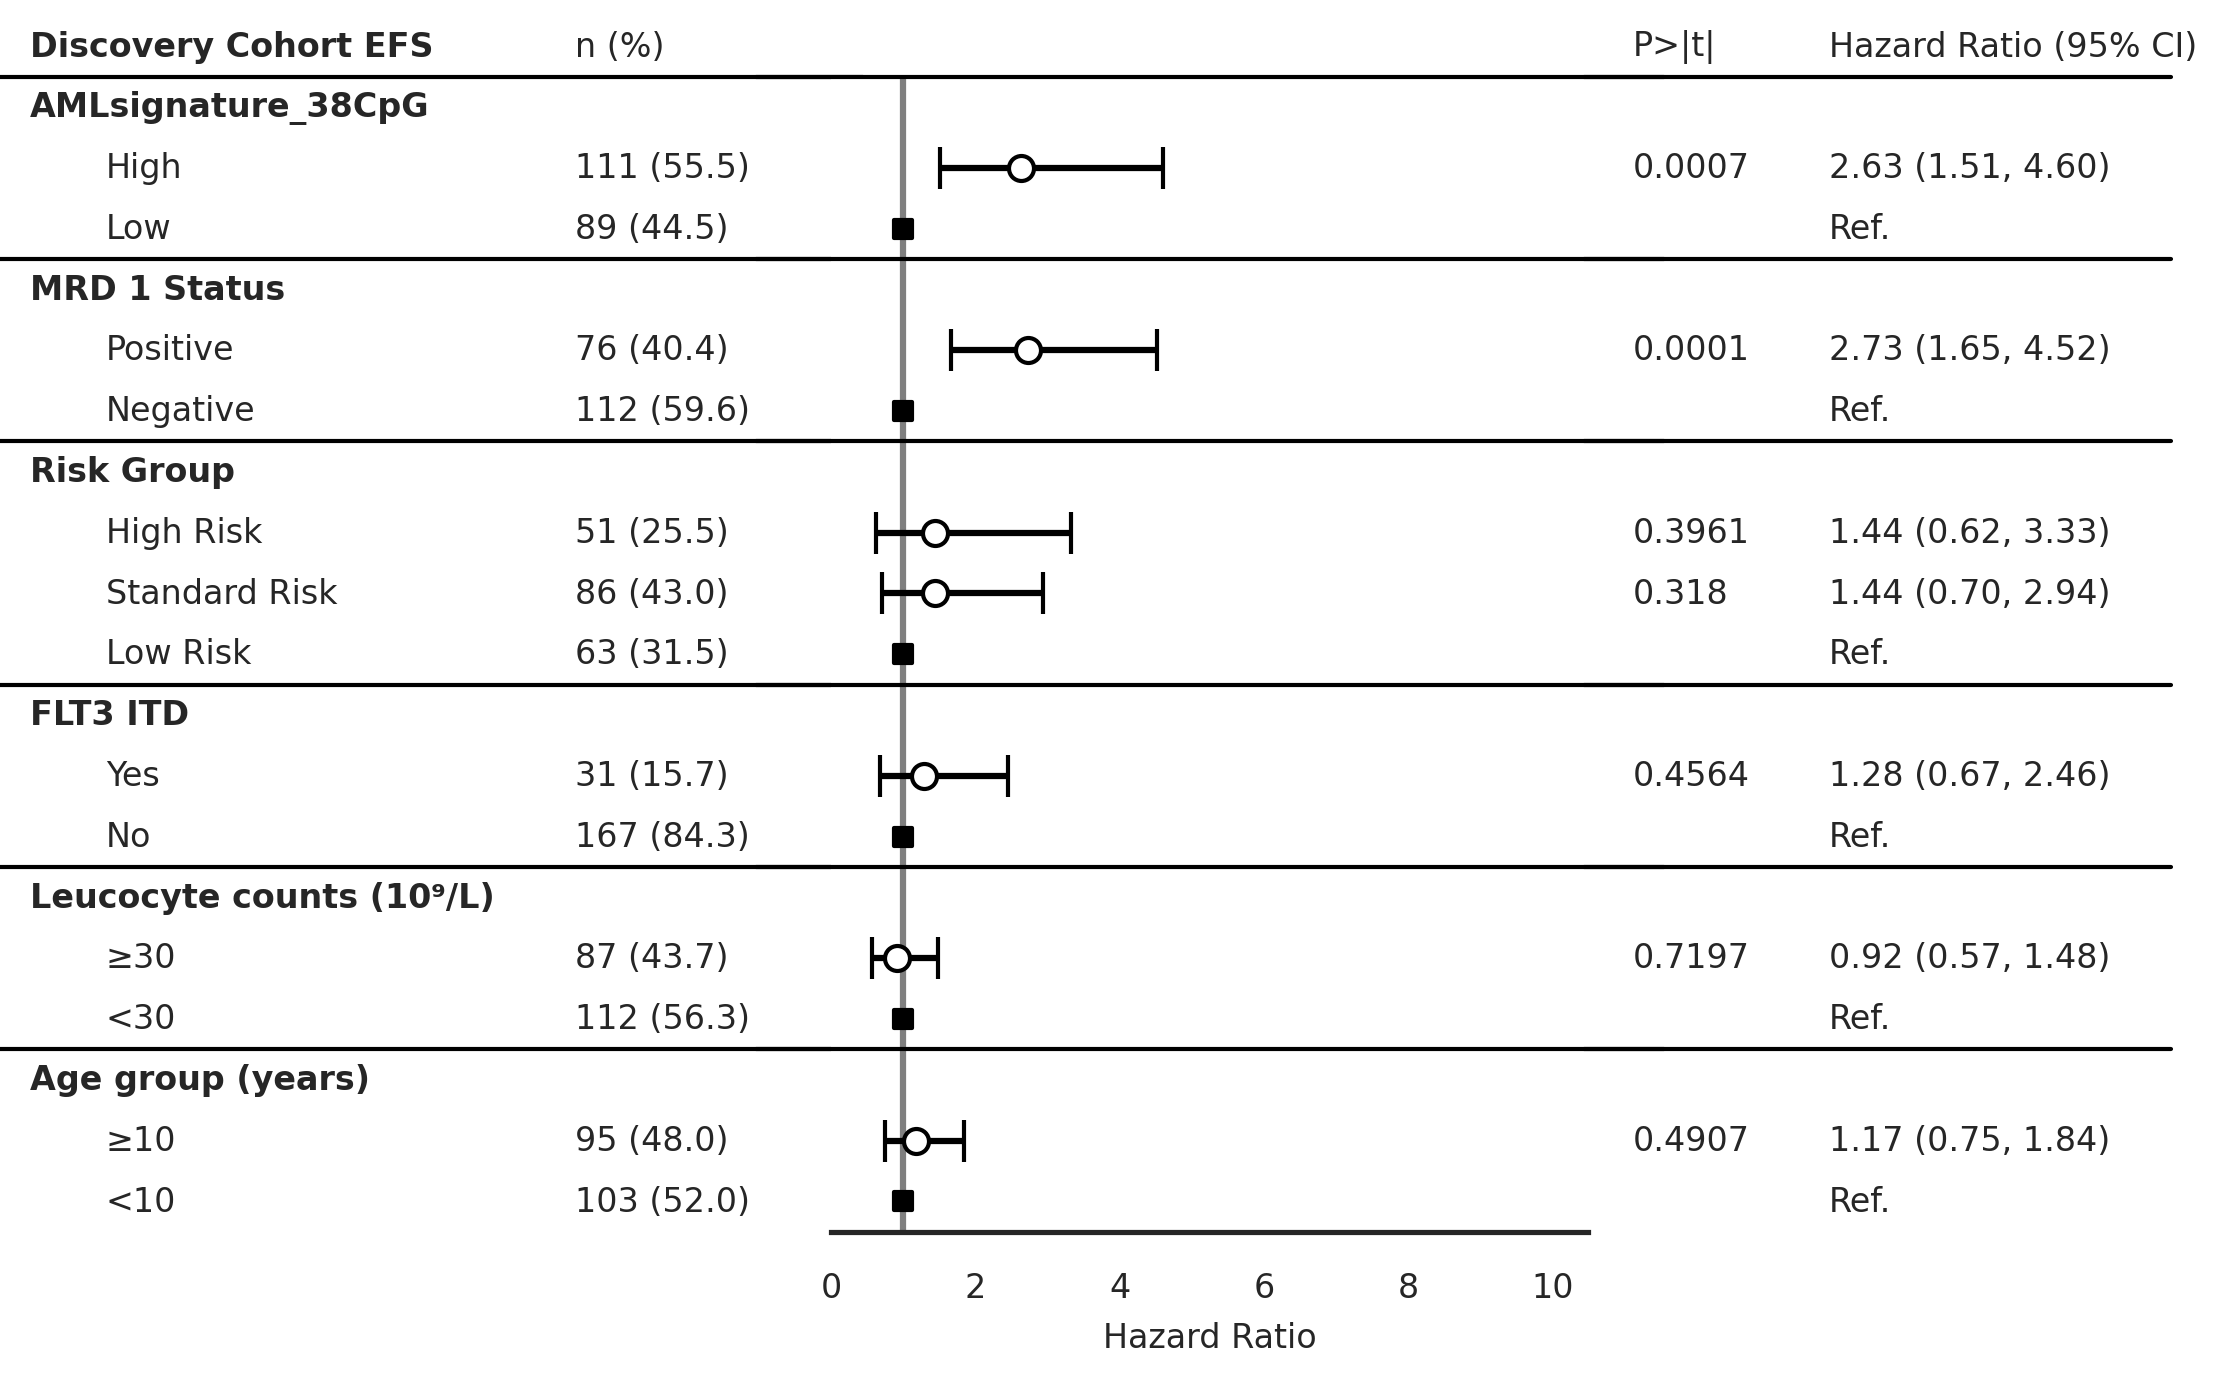

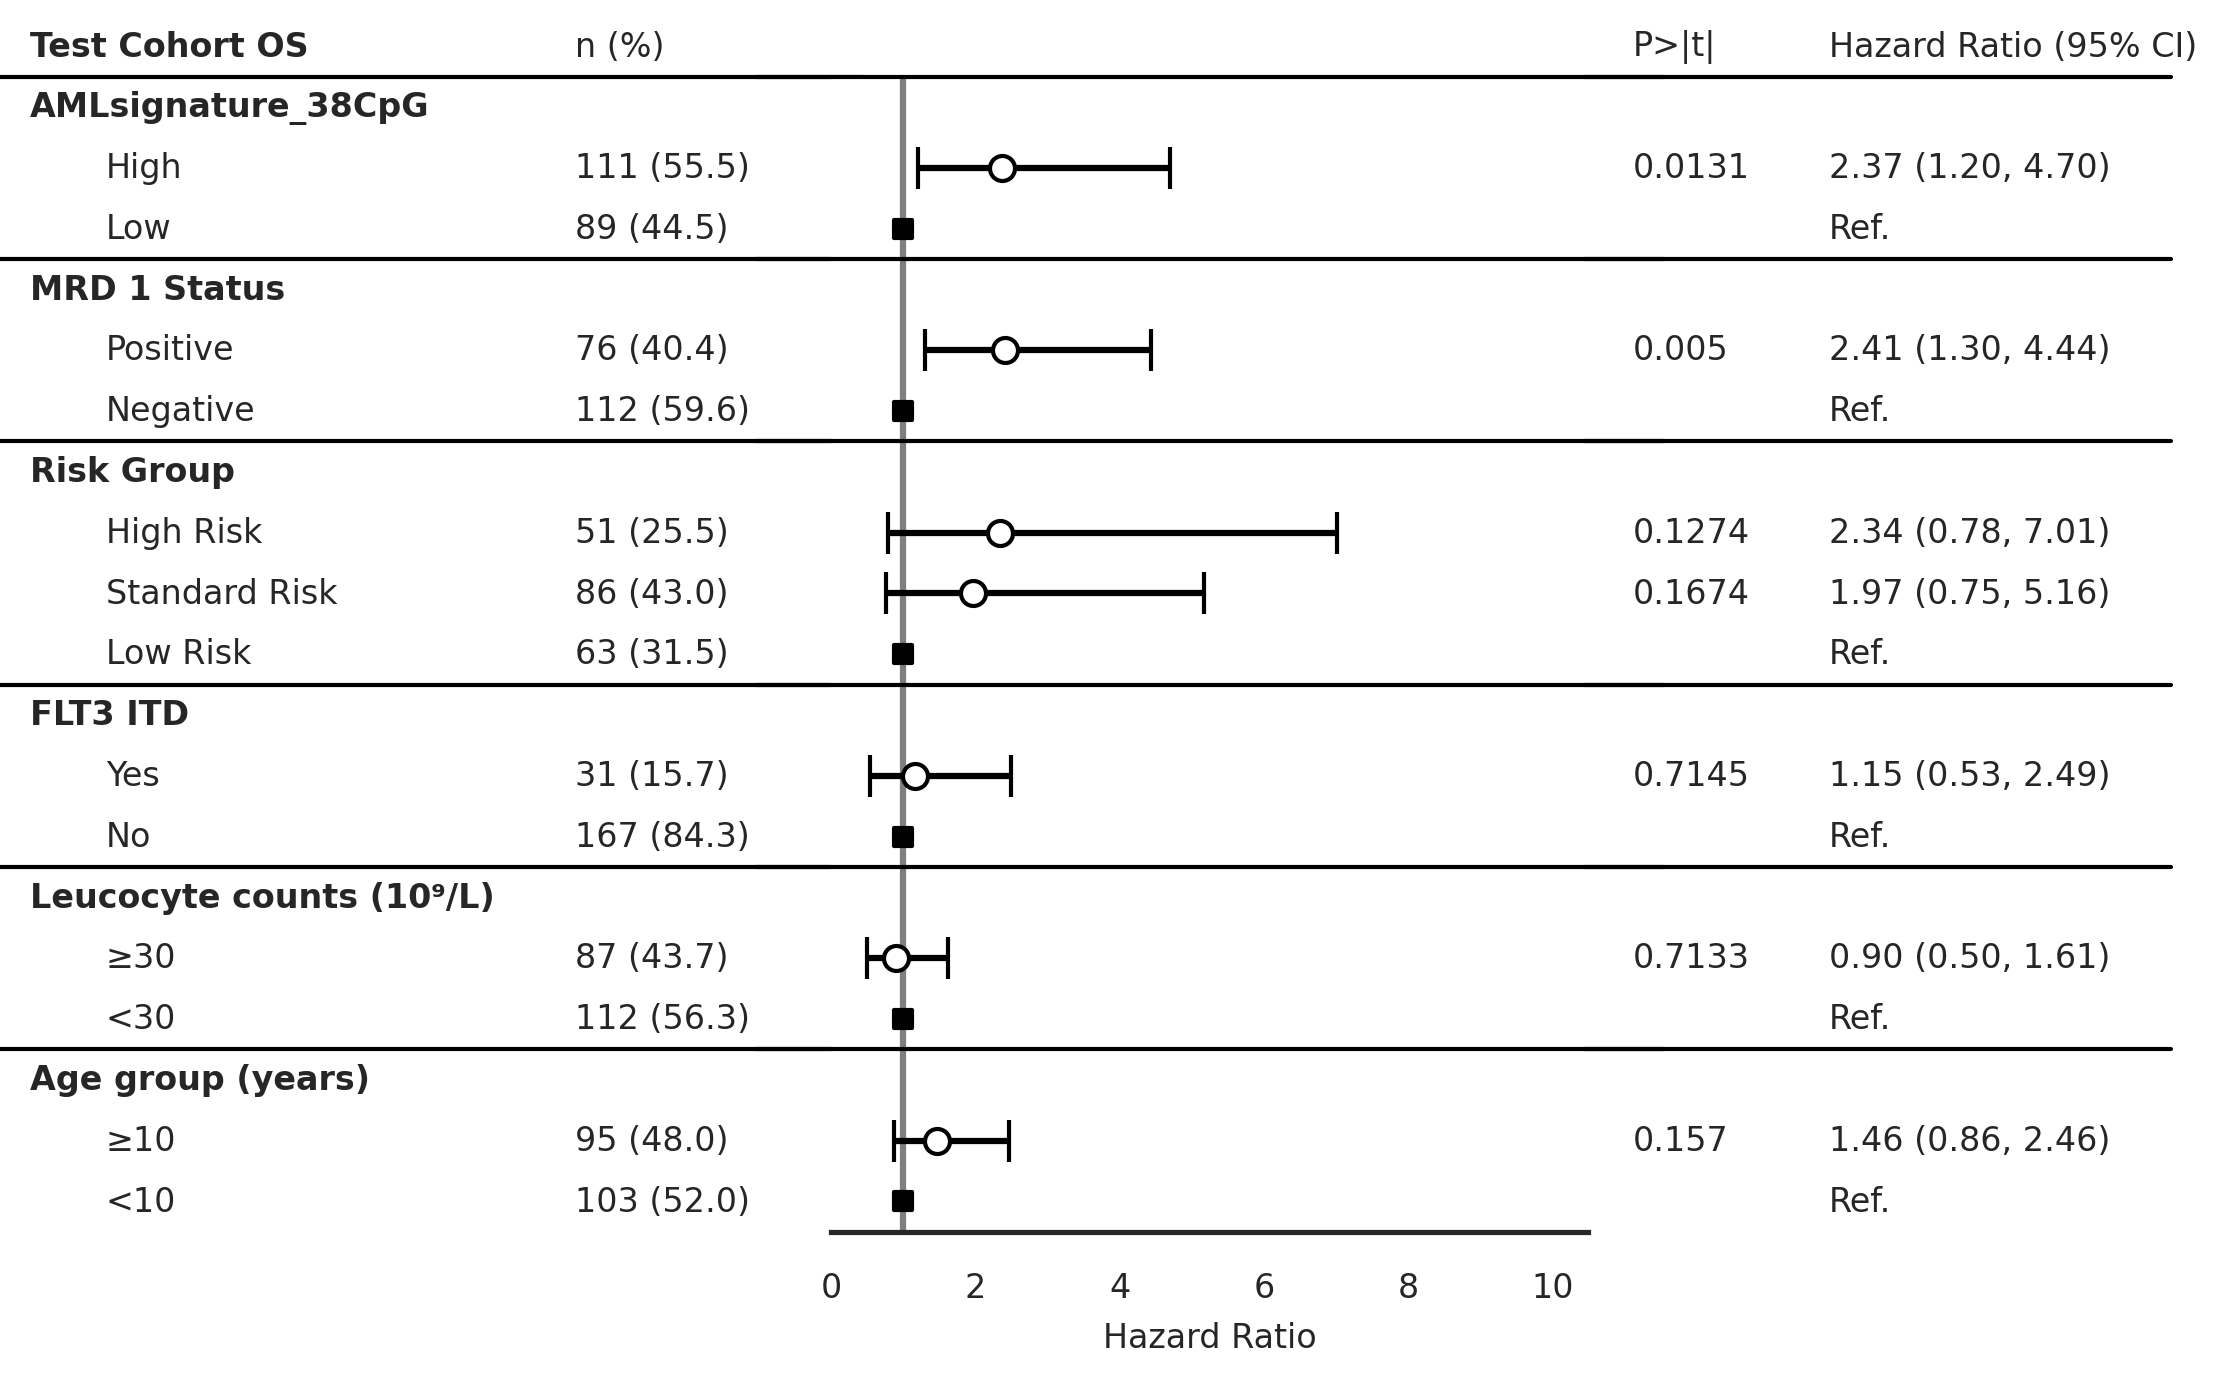

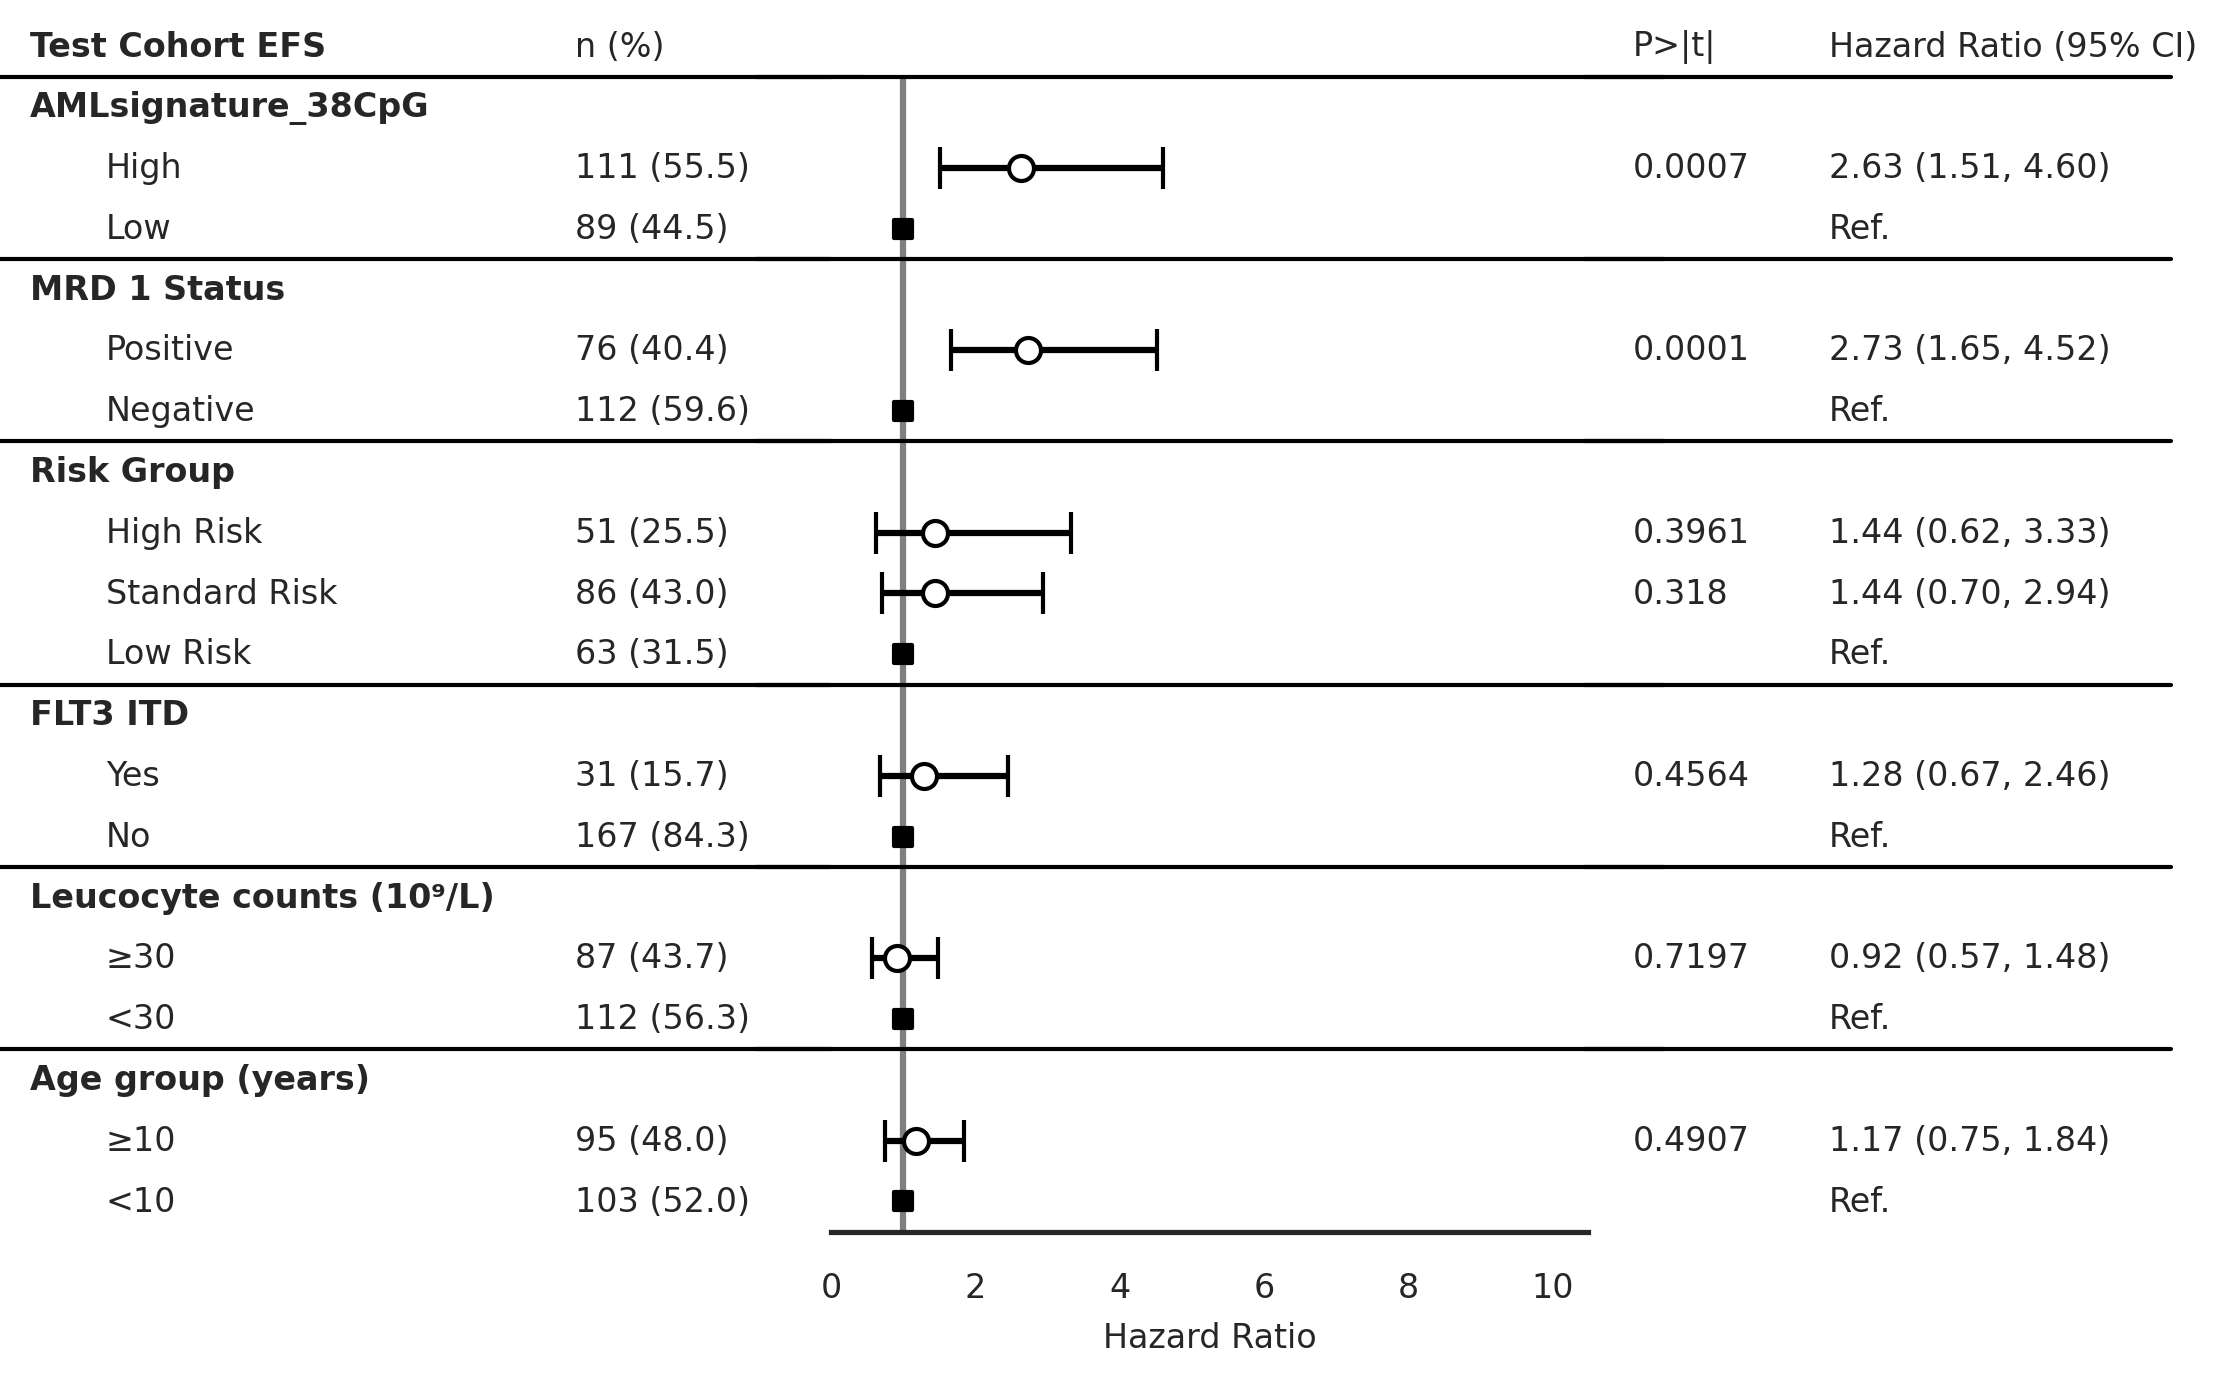

In [15]:
for dataset, trial in zip([df_px2, df_test], ['Discovery Cohort', 'Test Cohort']):


    draw_forest_plot(time='os_time_5y',
                        event='os_evnt_5y',
                        df=df_,
                        trialname=trial,
                        model_name='AMLsignature_38CpG',
                        save_plot=False)

    draw_forest_plot(time='efs_time_5y',
                        event='efs_evnt_5y',
                        df=df_,
                        trialname=trial,
                        model_name='AMLsignature_38CpG',
                        save_plot=False)

## ROC AUC performance

### Diagnostic Model

In [16]:
def process_dataset_for_multiclass_auc(df):
    # One hot encode `df_dx['AL Epigenomic Subtype']`
    df_dx_dummies = pd.get_dummies(df['WHO 2022 Diagnosis'])

    # transform boolean columns to integer
    df_dx_dummies = df_dx_dummies.astype(int)

    # join the one hot encoded columns with the original dataframe
    df_dx_auc = pd.concat([df.iloc[:, -34:-6], df_dx_dummies], axis=1)

    return df_dx_auc, df_dx_dummies

df_dx_auc_train, df_dx_dummies_train = process_dataset_for_multiclass_auc(df_dx)
df_dx_auc_test, df_dx_dummies_test = process_dataset_for_multiclass_auc(df_test)

p1 = plot_multiclass_roc_auc(df_dx_auc_train, df_dx_dummies_train.columns, title='Discovery Cohort', height=900, width=400, fontsize='9pt')
p2 = plot_multiclass_roc_auc(df_dx_auc_test, df_dx_dummies_test.columns, title='Test Cohort', height=900, width=400, fontsize='9pt')

# Create a gridplot
p = gridplot([[p1, p2]], toolbar_location='above')

show(p)

### Prognostic models

#### Discovery

In [17]:
def process_dataframes(df, model_name2, model_name3):

    df_cat = df[['os.evnt at 5y', model_name2, model_name3]]
    df_cont = df[['os.evnt at 5y', '38CpG-HazardScore', 'P(Death) at 5y']]

    df_cont = df_cont.rename(columns={
        'P(Death) at 5y': 'AML Epigenomic Risk (PaCMAP-LGBM)',
        '38CpG-HazardScore': '38CpG-AMLsignature (EWAS-CoxPH)'
    })

    df_cat = df_cat.rename(columns={
        model_name2: model_name2 + ' (PaCMAP-LGBM)',
        model_name3: model_name3 + ' (EWAS-CoxPH)'
    })

    return df_cat, df_cont

df_cat, df_cont = process_dataframes(df_px2, model_name2, model_name3)

risk = df_px2[['Risk Group AAML1831','Risk Group']]

low_high_dict = {'Low': 0, 'Low Risk': 0,
                'Standard':0.5, 'Standard Risk': 0.5,
                'High': 1, 'High Risk': 1}

risk['Risk Group'] = risk['Risk Group'].map(low_high_dict)
risk['Risk Group AAML1831'] = risk['Risk Group AAML1831'].map(low_high_dict)

df_cat['AML Epigenomic Risk (PaCMAP-LGBM)'] = df_cat['AML Epigenomic Risk (PaCMAP-LGBM)'].map(low_high_dict)
df_cat['38CpG-AMLsignature (EWAS-CoxPH)'] = df_cat['38CpG-AMLsignature (EWAS-CoxPH)'].map(low_high_dict)

df_cont_risk = df_cont.join(risk)
df_cat_risk = df_cat.join(risk)

df_cont_risk = df_cont_risk.fillna(0.5)
df_cat_risk = df_cat_risk.fillna(0.5)

p1 = plot_roc_auc(df_cont_risk, 'os.evnt at 5y',title= 'Continuous (prob. of death at 5y)')
p2 = plot_roc_auc(df_cat_risk, 'os.evnt at 5y',title= 'Categorical (high-low risk)')

# Create a gridplot
p = gridplot([[p1, p2]], toolbar_location='above')

show(p)

#### Test

In [18]:
df_cat, df_cont = process_dataframes(df_test, model_name2, model_name3)

risk = df_test[['Risk Group']]
risk['Risk Group'] = risk['Risk Group'].map(low_high_dict)

df_cat['AML Epigenomic Risk (PaCMAP-LGBM)'] = df_cat['AML Epigenomic Risk (PaCMAP-LGBM)'].map(low_high_dict)
df_cat['38CpG-AMLsignature (EWAS-CoxPH)'] = df_cat['38CpG-AMLsignature (EWAS-CoxPH)'].map(low_high_dict)

df_cont_risk_test = df_cont.join(risk)
df_cat_risk_test = df_cat.join(risk)

# Rename `Risk Group` to `Risk Group AML02,08`
df_cont_risk_test = df_cont_risk_test.rename(columns={'Risk Group':'Risk Group AML02-08'})
df_cat_risk_test = df_cat_risk_test.rename(columns={'Risk Group':'Risk Group AML02-08'})

p1 = plot_roc_auc(df_cont_risk_test, 'os.evnt at 5y',title= 'Continuous (prob. of death at 5y)')
p2 = plot_roc_auc(df_cat_risk_test, 'os.evnt at 5y',title= 'Categorical (high-low risk)')

# Create a gridplot
p = gridplot([[p1, p2]], toolbar_location='above')

show(p)


## Pearson Correlation

### Discovery

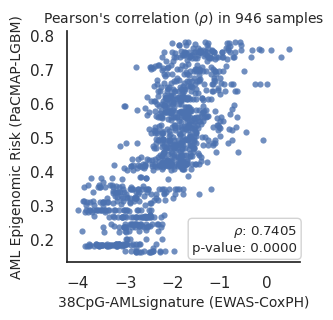

38CpG-AMLsignature (EWAS-CoxPH)  \
38CpG-AMLsignature (EWAS-CoxPH)                               1.00   
AML Epigenomic Risk (PaCMAP-LGBM)                             0.74   
Risk Group AAML1831                                           0.50   
Risk Group                                                    0.54   

                                   AML Epigenomic Risk (PaCMAP-LGBM)  \
38CpG-AMLsignature (EWAS-CoxPH)                                 0.74   
AML Epigenomic Risk (PaCMAP-LGBM)                               1.00   
Risk Group AAML1831                                             0.53   
Risk Group                                                      0.59   

                                   Risk Group AAML1831  Risk Group  
38CpG-AMLsignature (EWAS-CoxPH)                   0.50        0.54  
AML Epigenomic Risk (PaCMAP-LGBM)                 0.53        0.59  
Risk Group AAML1831                               1.00        0.62  
Risk Group                                        0.62        1.00

In [19]:
draw_scatter_pearson(df=df_cont_risk,x=model_name3 + ' (EWAS-CoxPH)', y=model_name2 + ' (PaCMAP-LGBM)',s=20)

df_cont_risk.iloc[:,1:].corr().round(2)

### Test

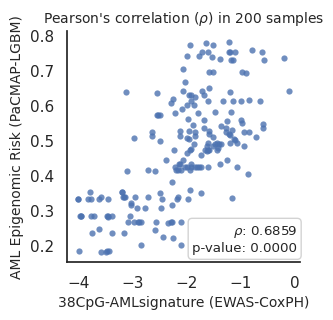

38CpG-AMLsignature (EWAS-CoxPH)  \
38CpG-AMLsignature (EWAS-CoxPH)                               1.00   
AML Epigenomic Risk (PaCMAP-LGBM)                             0.69   
Risk Group AML02-08                                           0.46   

                                   AML Epigenomic Risk (PaCMAP-LGBM)  \
38CpG-AMLsignature (EWAS-CoxPH)                                 0.69   
AML Epigenomic Risk (PaCMAP-LGBM)                               1.00   
Risk Group AML02-08                                             0.51   

                                   Risk Group AML02-08  
38CpG-AMLsignature (EWAS-CoxPH)                   0.46  
AML Epigenomic Risk (PaCMAP-LGBM)                 0.51  
Risk Group AML02-08                               1.00

In [20]:
draw_scatter_pearson(df=df_cont_risk_test,x=model_name3 + ' (EWAS-CoxPH)', y=model_name2 + ' (PaCMAP-LGBM)',s=20)

df_cont_risk_test.iloc[:,1:].corr().round(2)

## Sankey plots

```{note}
Sankey plots below compare the distribution of categories. The width of the lines is proportional to the number of patients in each group.
```

### Samples with annotated diagnosis info

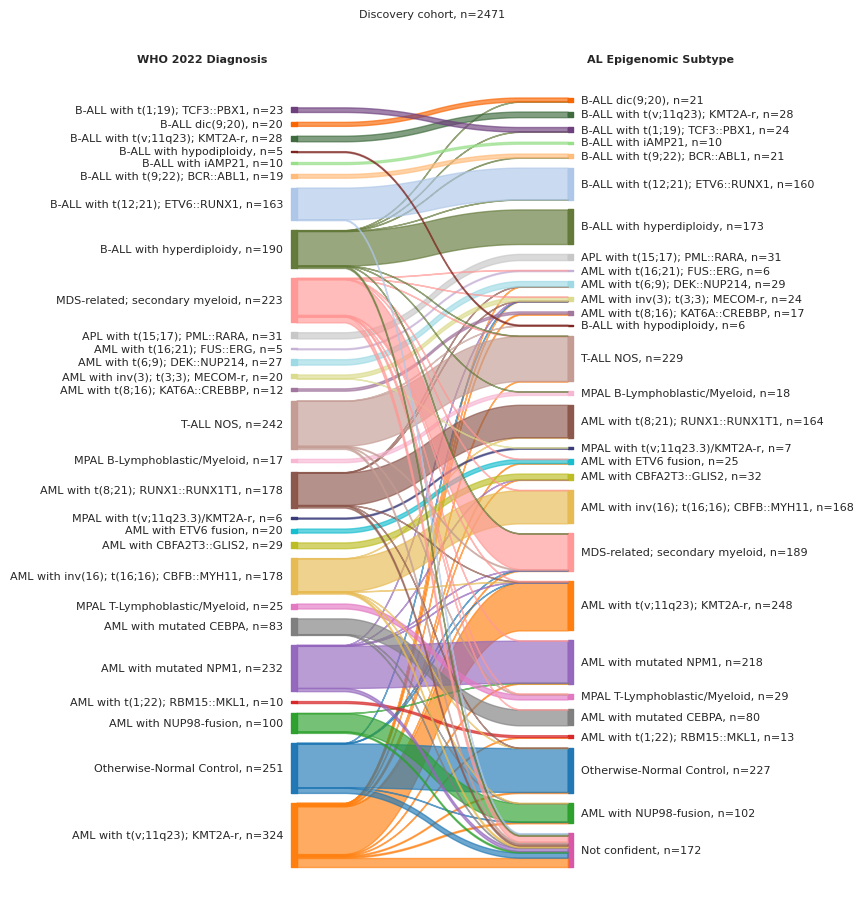

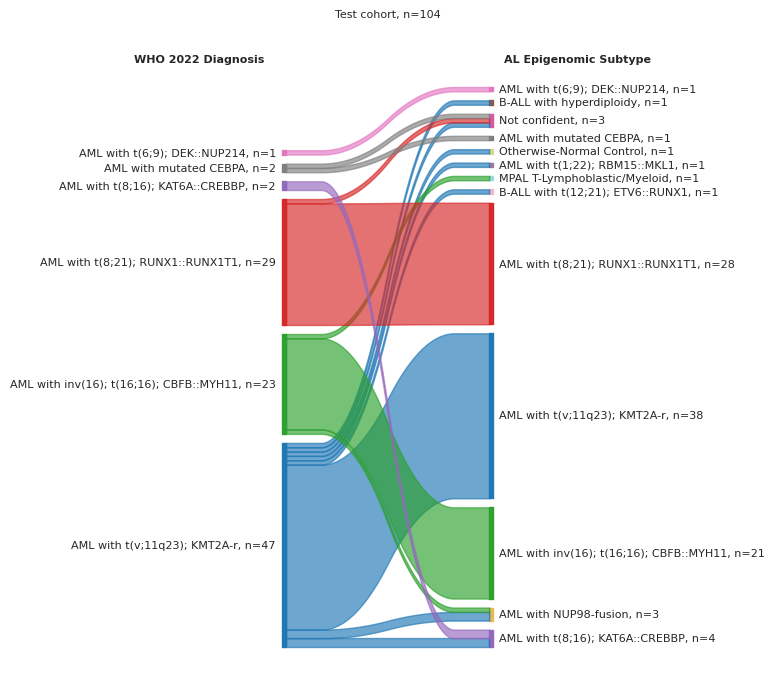

In [21]:
colors = get_custom_color_palette()


draw_sankey_plot(df_dx, 'WHO 2022 Diagnosis', model_name1, colors,
                 title='Discovery cohort', fig_size=(4, 11),
                 fontsize=8, nan_action='drop')

draw_sankey_plot(df_test, 'WHO 2022 Diagnosis', model_name1, colors,
                 title= 'Test cohort',fig_size=(3, 8),
                 fontsize=8, nan_action='drop')

### Predictions in samples for which no WHO 22 Dx data was available

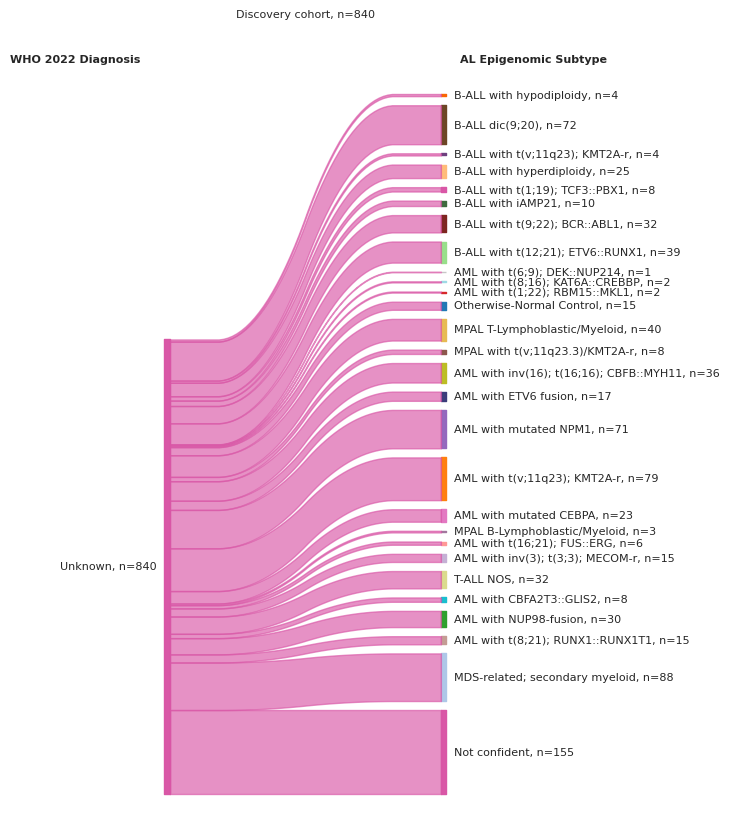

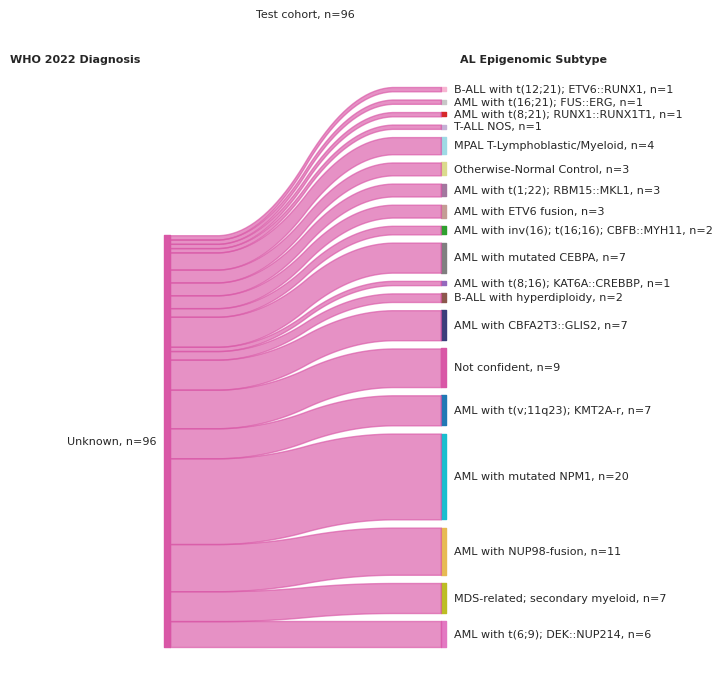

In [22]:
draw_sankey_plot(df_train, 'WHO 2022 Diagnosis', model_name1, colors,
                 title='Discovery cohort', fig_size=(4, 10),
                 fontsize=8, nan_action='keep only')

draw_sankey_plot(df_test, 'WHO 2022 Diagnosis', model_name1, colors,
                 title= 'Test cohort',fig_size=(4, 8),
                 fontsize=8, nan_action='keep only')

### Reason for unclassified samples

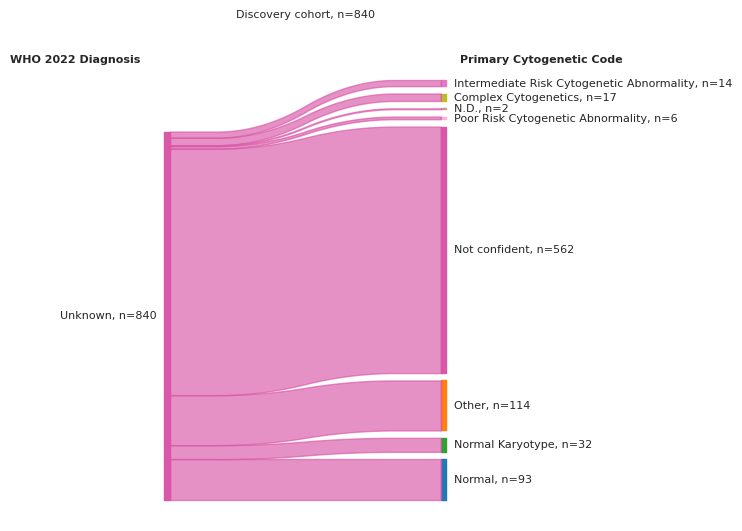

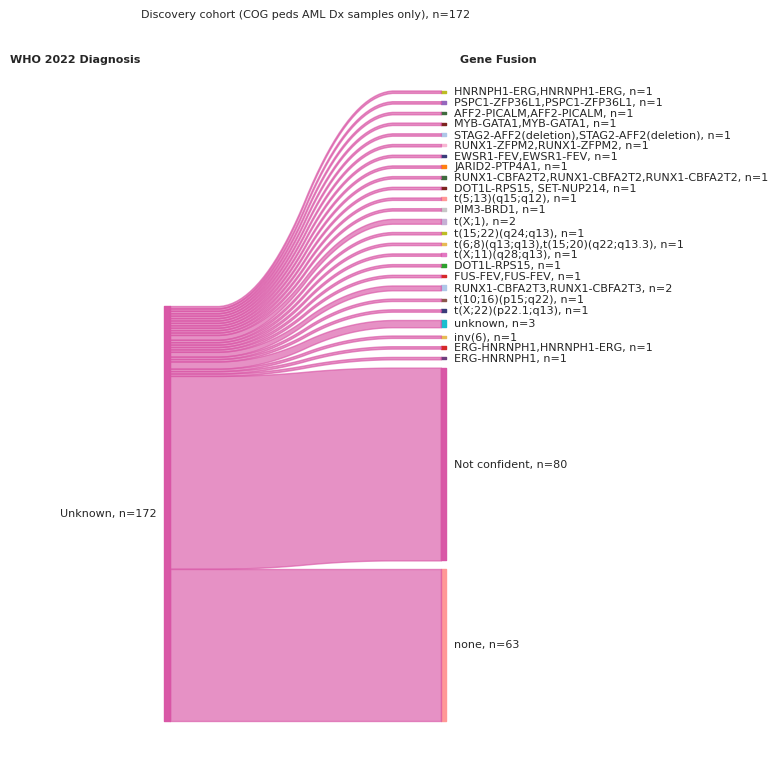

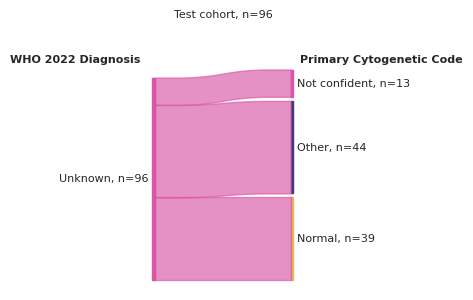

In [23]:
draw_sankey_plot(df_train, 'WHO 2022 Diagnosis', 'Primary Cytogenetic Code', colors,
                 title='Discovery cohort', fig_size=(4, 6),
                 fontsize=8, nan_action='keep only')

draw_sankey_plot(df_px2, 'WHO 2022 Diagnosis', 'Gene Fusion', colors,
                 title= 'Discovery cohort (COG peds AML Dx samples only)',fig_size=(4, 9),
                 fontsize=8, nan_action='keep only')

draw_sankey_plot(df_test, 'WHO 2022 Diagnosis', 'Primary Cytogenetic Code', colors,
                 title= 'Test cohort',fig_size=(2, 3),
                 fontsize=8, nan_action='keep only')

### Risk group comparison in COG

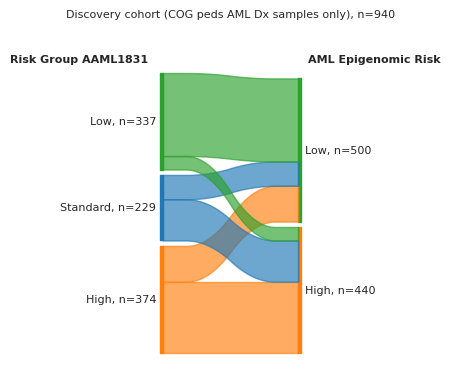

In [24]:
draw_sankey_plot(df_px2, 'Risk Group AAML1831', 'AML Epigenomic Risk', colors,
                 title= 'Discovery cohort (COG peds AML Dx samples only)',fig_size=(2, 4),
                 fontsize=8, nan_action='drop')

### Nanopore test results

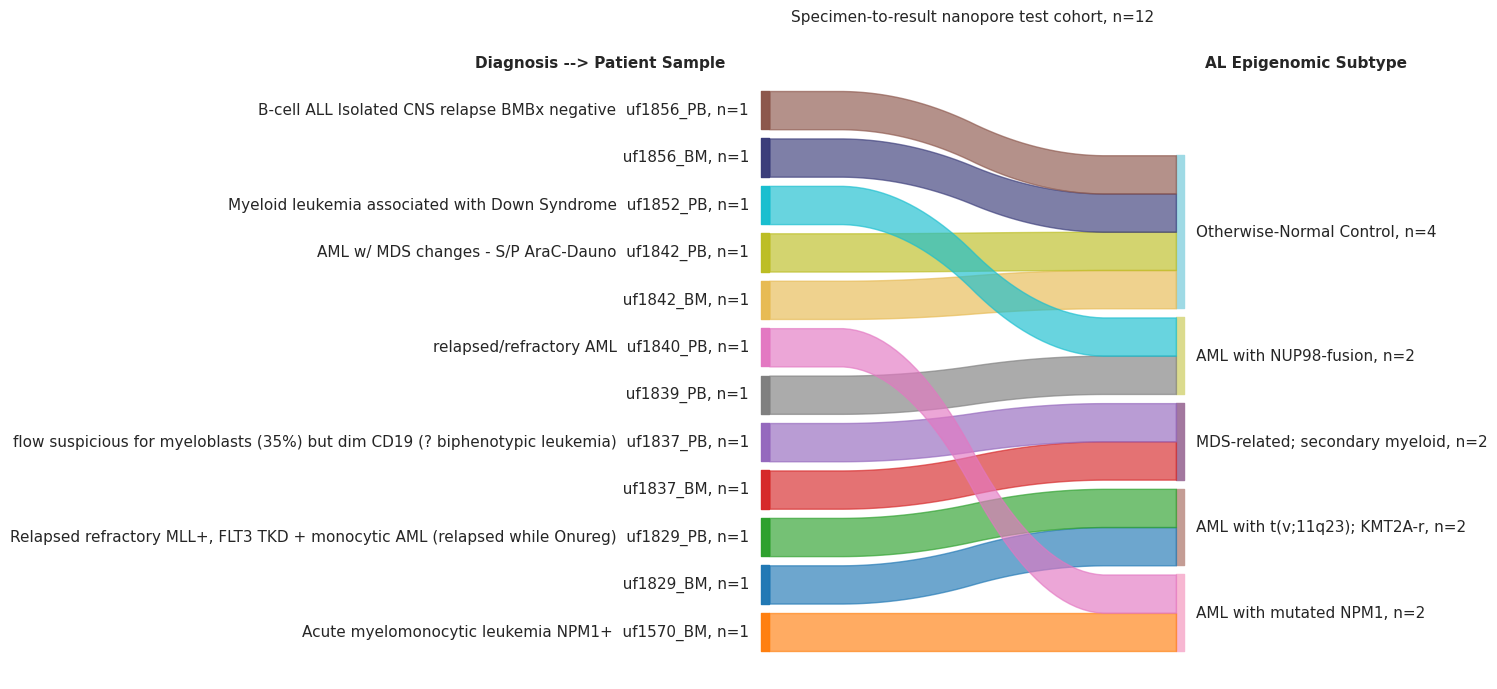

In [25]:
dfsank = df[df['Clinical Trial'] == 'UF HemBank']
dfsank = dfsank.reset_index()

# If values are repeated in dfsank['Dx at Acquisition], replace second value with empty string
dfsank['Dx at Acquisition'] = dfsank['Dx at Acquisition'].where(~dfsank['Dx at Acquisition'].duplicated(keep='last'), '')

dfsank['Diagnosis --> Patient Sample'] = dfsank['Dx at Acquisition'] + '  ' + dfsank['index']

draw_sankey_plot(dfsank, 'Diagnosis --> Patient Sample',model_name1,
                 title= 'Specimen-to-result nanopore test cohort',fig_size=(6, 8),
                 fontsize=11, nan_action='drop', colors=colors)

## Performance metrics

### AML Epigenomic Risk

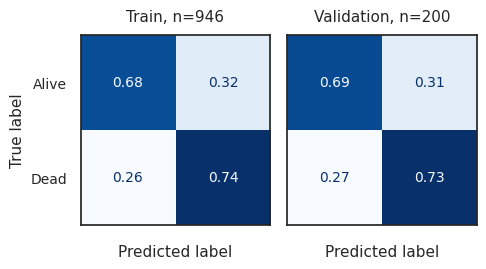


Metrics:
|            |   Accuracy |   Sensitivity |   Specificity |   Precision |   F1-score |   AUC-ROC |
|:-----------|-----------:|--------------:|--------------:|------------:|-----------:|----------:|
| Train      |      0.704 |         0.74  |         0.684 |       0.566 |      0.641 |     0.712 |
| Validation |      0.7   |         0.733 |         0.686 |       0.5   |      0.595 |     0.71  |


In [26]:
plot_confusion_matrix_stacked(df_px2, df_test, 'os.evnt at 5y', model_name2+'_int','os.evnt at 5y')

### 38CpG-AMLsignature

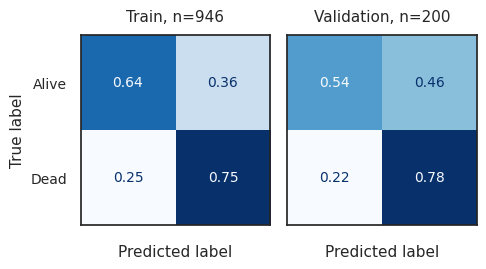


Metrics:
|            |   Accuracy |   Sensitivity |   Specificity |   Precision |   F1-score |   AUC-ROC |
|:-----------|-----------:|--------------:|--------------:|------------:|-----------:|----------:|
| Train      |      0.675 |         0.746 |         0.637 |       0.533 |      0.621 |     0.691 |
| Validation |      0.615 |         0.783 |         0.543 |       0.423 |      0.55  |     0.663 |


In [27]:
plot_confusion_matrix_stacked(df_px2, df_test, 'os.evnt at 5y', model_name3 + '_int','os.evnt at 5y')

### AL Epigenomic Subtype

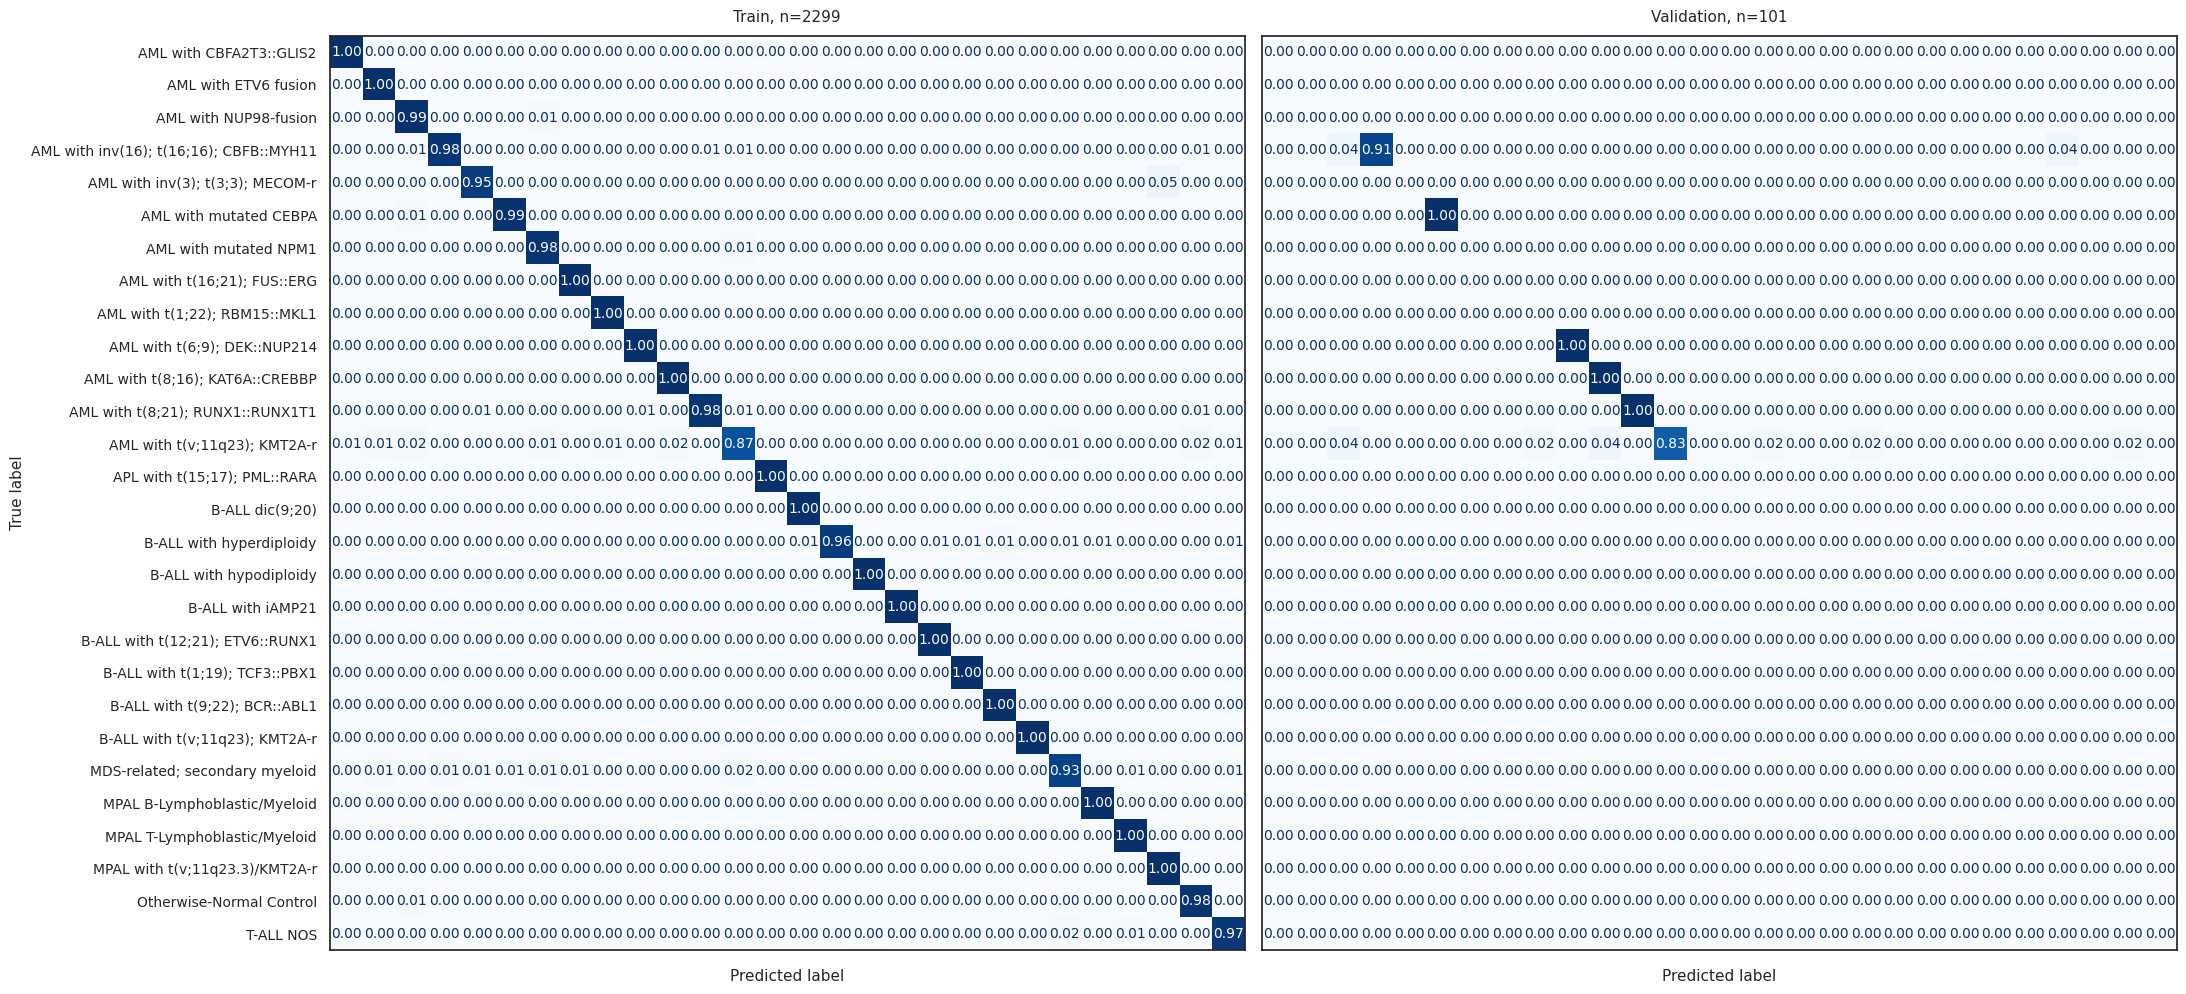


Metrics:
|            |   Accuracy |   Macro F1 |   Weighted F1 |   Cohen's Kappa |
|:-----------|-----------:|-----------:|--------------:|----------------:|
| Train      |      0.963 |      0.948 |         0.963 |           0.96  |
| Validation |      0.901 |      0.46  |         0.94  |           0.859 |


In [28]:
plot_confusion_matrix_stacked(df_dx, df_test, 'WHO 2022 Diagnosis', model_name1, 'WHO 2022 Diagnosis', figsize=(22,14))

```{note}
Samples from the training and test sets without WHO 2022 diagnosis data or with inconclusive model predictions were excluded from this confusion matrix.
```

## Box plots

### AML Epigenomic Risk

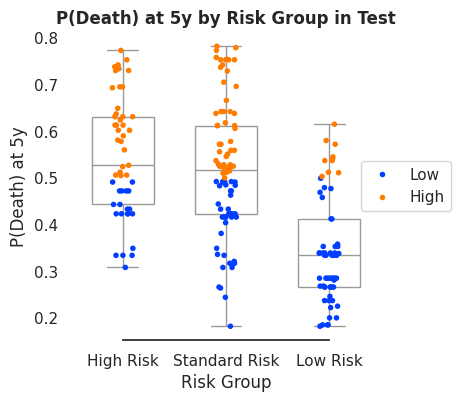

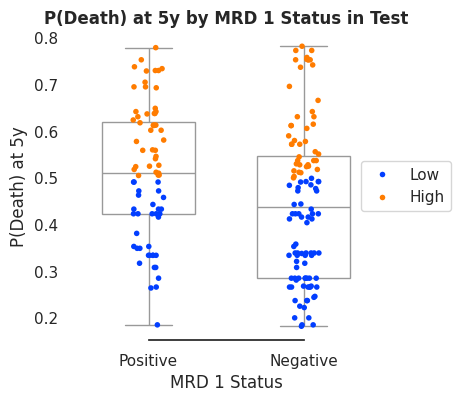

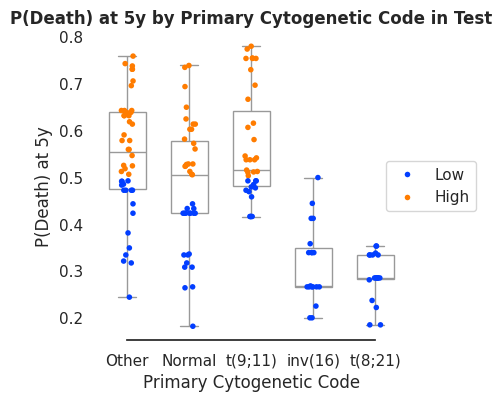

In [29]:
draw_boxplot(df=df_test,x='Risk Group', y='P(Death) at 5y',
                order=['High Risk', 'Standard Risk', 'Low Risk'],
                trialname='Test', hue=model_name2,
                save_plot=False, figsize=(4,4))

draw_boxplot(df=df_test,x='MRD 1 Status', y='P(Death) at 5y',
                order=['Positive','Negative'],
                trialname='Test', hue=model_name2,
                save_plot=False, figsize=(4,4))

draw_boxplot(df=df_test,x='Primary Cytogenetic Code', y='P(Death) at 5y',
                order='auto',
                trialname='Test', hue=model_name2,
                save_plot=False, figsize=(4,4))

### 38CpG-AMLsignature

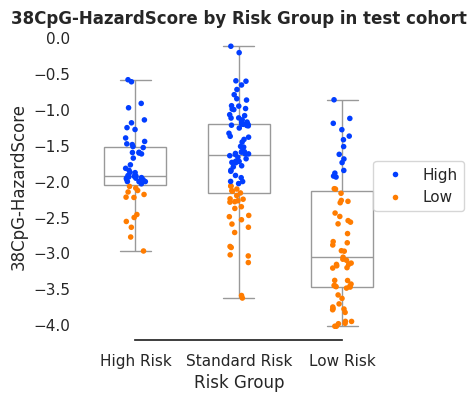

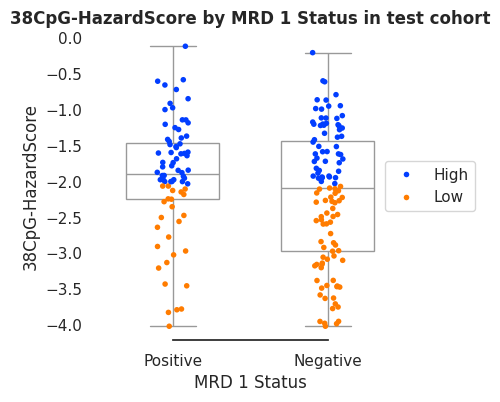

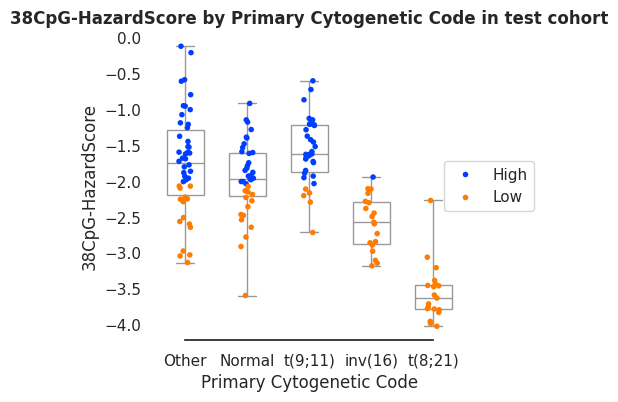

In [30]:
draw_boxplot(df=df_test,x='Risk Group', y='38CpG-HazardScore',
                order=['High Risk', 'Standard Risk', 'Low Risk'],
                trialname='test cohort', hue=model_name3,
                save_plot=False, figsize=(4,4))

draw_boxplot(df=df_test,x='MRD 1 Status', y='38CpG-HazardScore',
                order=['Positive','Negative'],
                trialname='test cohort', hue=model_name3,
                save_plot=False, figsize=(4,4))

draw_boxplot(df=df_test,x='Primary Cytogenetic Code', y='38CpG-HazardScore',
                order='auto',
                trialname='test cohort', hue=model_name3,
                save_plot=False, figsize=(4,4))

## Stacked bar plots

### AML Epigenomic Risk

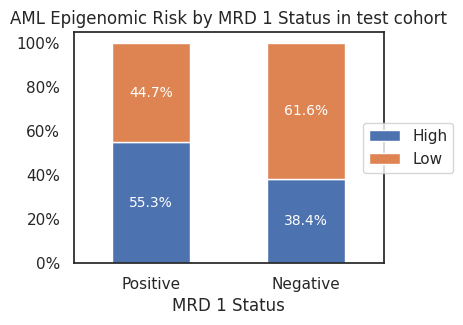

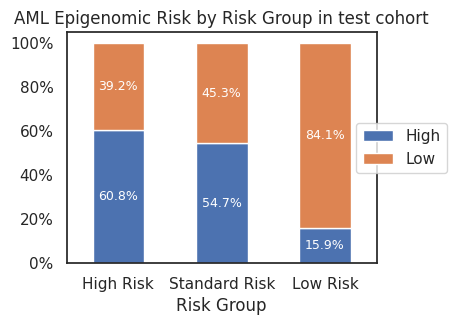

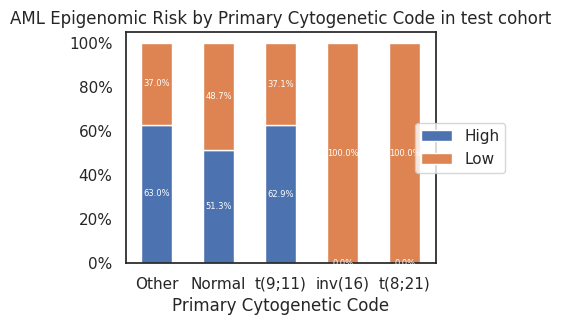

In [31]:
draw_stacked_barplot(df=df_test,x='MRD 1 Status', y=model_name2,
             order=['Positive','Negative'],
             trialname='test cohort', hue=model_name2,
             save_plot=False, figsize=(4,3))

draw_stacked_barplot(df=df_test,x='Risk Group', y=model_name2,
                order=['High Risk', 'Standard Risk', 'Low Risk'],
                trialname='test cohort', hue=model_name2,
                save_plot=False, figsize=(4,3), fontsize=9)

draw_stacked_barplot(df=df_test,x='Primary Cytogenetic Code', y=model_name2,
                order='auto',
                trialname='test cohort', hue=model_name2,
                save_plot=False, figsize=(4,3), fontsize=6)

### 38CpG-AMLsignature

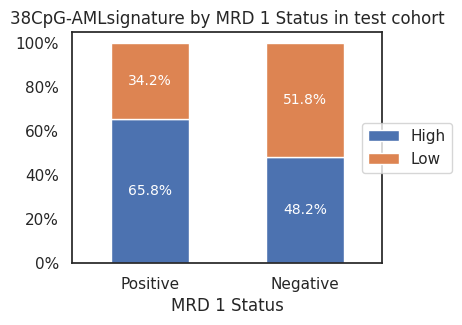

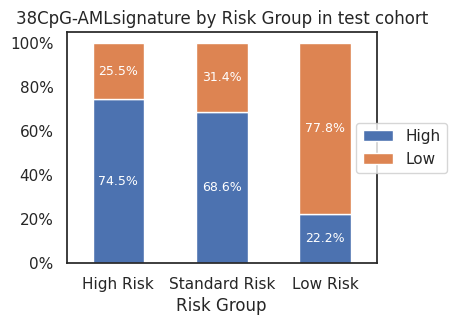

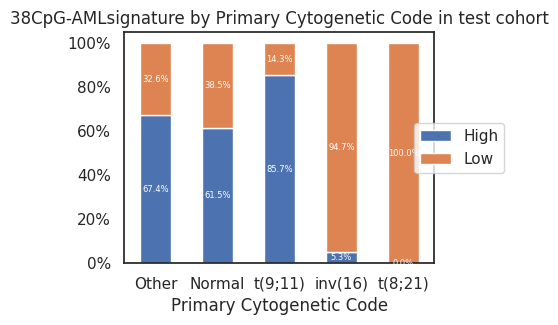

In [32]:
draw_stacked_barplot(df=df_test,x='MRD 1 Status', y=model_name3,
             order=['Positive','Negative'],
             trialname='test cohort', hue=model_name3,
             save_plot=False, figsize=(4,3))

draw_stacked_barplot(df=df_test,x='Risk Group', y=model_name3,
                order=['High Risk', 'Standard Risk', 'Low Risk'],
                trialname='test cohort', hue=model_name3,
                save_plot=False, figsize=(4,3), fontsize=9)

draw_stacked_barplot(df=df_test,x='Primary Cytogenetic Code', y=model_name3,
                order='auto',
                trialname='test cohort', hue=model_name3,
                save_plot=False, figsize=(4,3), fontsize=6)

## Watermark

In [33]:
%load_ext watermark

In [34]:
# watermark with all libraries used in this notebook
%watermark -v -p pandas,seaborn,matplotlib,tableone,sklearn,lifelines,scipy -a Francisco_Marchi@Lamba_Lab_UF -d -m -r -u

Author: Francisco_Marchi@Lamba_Lab_UF

Last updated: 2024-09-20

Python implementation: CPython
Python version       : 3.10.13
IPython version      : 8.27.0

pandas    : 2.2.2
seaborn   : 0.13.2
matplotlib: 3.9.2
tableone  : 0.8.0
sklearn   : 1.5.2
lifelines : 0.28.0
scipy     : 1.12.0

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 5.15.133.1-microsoft-standard-WSL2
Machine     : x86_64
Processor   : x86_64
CPU cores   : 32
Architecture: 64bit

Git repo: git@github.com:f-marchi/ALMA.git

